# 顧客セグメンテーション

## 目的

- Eコマース購買履歴データを分析。
- 新しい顧客の最初の購入から翌年以降にその顧客が行う行動（購入）を予測するモデルを開発する

### データ

- 期間：2010/12/01 ～ 2011/12/09
- 顧客数：4000人（年間） 

#### フォーマット
- InvoiceNo：請求書番号。名目、各トランザクションに一意に割り当てられた6桁の整数。このコードが文字「c」で始まる場合、キャンセルを示す
- StockCode：製品（アイテム）コード。名義、各個別の製品に一意に割り当てられた5桁の整数。
- Description：製品（アイテム）名。名目。
- Quantity：トランザクションごとの各製品（アイテム）の数量。数値。
- InvoiceDate：Inviceの日付と時刻。数値、各トランザクションが生成された日時。
- UnitPrice：単価。数値、英ポンド単位あたりの製品価格。
- CustomerID：顧客番号。名義、各顧客に一意に割り当てられた5桁の整数。
- Country：国名。名義、各顧客が居住する国の名前

## 概略

- データ準備
- データ可視化
  - 地域
- データ探索・クレンジング
  - 顧客と製品
  - キャンセル注文
  - StockCode
  - 注文合計金額
 
- データ・エンリッチメント
  - 製品カテゴリの定義
    - データのエンコード
    - 製品クラスタリング
    - クラスターのコンテンツの特徴付け

- 特徴量エンジニアリング
  - データのフォーマット
    - 製品のグループ化
    - データセットの時間分割
    - 注文のグループ化
  - 顧客カテゴリの作成
    - データエンコード
    - カテゴリーの作成

- 顧客クラス分類
  - サポートベクターマシン分類子（SVC）
    - 混同マトリックス
    - 学習曲線
  - ロジスティック回帰
  - k最近傍
  - 決定木
  - ランダムフォレスト
  - AdaBoost
  - 勾配ブースティング分類器
  - VotingClassifier

- 予測性能検証

- 結論

利用モジュール定義

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

## データ準備

データを読み込み、データ型、欠損値、データ数合計を確認

In [7]:
#__________________
# read the datafile
df_initial = pd.read_csv('./input/data.csv',encoding="ISO-8859-1",
                         dtype={'CustomerID': str,'InvoiceID': str})
print('Dataframe dimensions:', df_initial.shape)
#______
df_initial['InvoiceDate'] = pd.to_datetime(df_initial['InvoiceDate'])
#____________________________________________________________
# gives some infos on columns types and numer of null values
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)

Dataframe dimensions: (541909, 8)


InvoiceNo StockCode Description Quantity     InvoiceDate  \
column type         object    object      object    int64  datetime64[ns]   
null values (nb)         0         0        1454        0               0   
null values (%)          0         0    0.268311        0               0   

                 UnitPrice CustomerID Country  
column type        float64     object  object  
null values (nb)         0     135080       0  
null values (%)          0    24.9267       0

データのサンプル（先頭５件）を確認

In [6]:
#__________________
# show first lines
display(df_initial[:5])

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice CustomerID         Country  
0 2010-12-01 08:26:00       2.55      17850  United Kingdom  
1 2010-12-01 08:26:00       3.39      17850  United Kingdom  
2 2010-12-01 08:26:00       2.75      17850  United Kingdom  
3 2010-12-01 08:26:00       3.39      17850  United Kingdom  
4 2010-12-01 08:26:00       3.39      17850  United Kingdom

利用不可データ（顧客ID欠損データ）を削除

In [4]:
df_initial.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
print('Dataframe dimensions:', df_initial.shape)
#____________________________________________________________
# gives some infos on columns types and numer of null values
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)

Dataframe dimensions: (406829, 8)


InvoiceNo StockCode Description Quantity     InvoiceDate  \
column type         object    object      object    int64  datetime64[ns]   
null values (nb)         0         0           0        0               0   
null values (%)          0         0           0        0               0   

                 UnitPrice CustomerID Country  
column type        float64     object  object  
null values (nb)         0          0       0  
null values (%)          0          0       0

重複データを削除

In [8]:
print('Duplicated entries: {}'.format(df_initial.duplicated().sum()))

Duplicated entries: 5268


In [9]:
df_initial.drop_duplicates(inplace = True)
print('Duplicated entries: {}'.format(df_initial.duplicated().sum()))

Duplicated entries: 0


## データ可視化

### 地域

地域区分（国）総数を確認

マップを使った可視化

In [8]:
data = dict(type='choropleth',
locations = countries.index,
locationmode = 'country names', z = countries,
text = countries.index, colorbar = {'title':'Order nb.'},
colorscale=[[0, 'rgb(224,255,255)'],
            [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
            [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
            [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
            [1, 'rgb(227,26,28)']],    
reversescale = False)
#_______________________
layout = dict(title='Number of orders per country',
geo = dict(showframe = True, projection={'type':'mercator'}))
#______________
choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate=False)

## データ探索・クレンジング

### 顧客と製品

データに含まれる製品、トランザクション、顧客の総数を確認

In [9]:
pd.DataFrame([{'products': len(df_initial['StockCode'].value_counts()),    
               'transactions': len(df_initial['InvoiceNo'].value_counts()),
               'customers': len(df_initial['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

products  transactions  customers
quantity      3684         22190       4372

一度の注文で購入した製品の数を確認。顧客IDでソートし、サンプル（先頭１０件）を表示

In [14]:
temp = df_initial.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket[:10].sort_values('CustomerID')

CustomerID InvoiceNo  Number of products
0      12346    541431                   1
1      12346   C541433                   1
2      12347    537626                  31
3      12347    542237                  29
4      12347    549222                  24
5      12347    556201                  18
6      12347    562032                  22
7      12347    573511                  47
8      12347    581180                  11
9      12348    539318                  17

下記の違いに注目することができる。
- 顧客ごとの注文数
- 注文ごとの購入品目の数

#### キャンセル注文

キャンセル注文を抽出し、トランザクション（購入製品）数をサンプル確認

In [15]:
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x:int('C' in x))
display(nb_products_per_basket[:5])

CustomerID InvoiceNo  Number of products  order_canceled
0      12346    541431                   1               0
1      12346   C541433                   1               1
2      12347    537626                  31               0
3      12347    542237                  29               0
4      12347    549222                  24               0

総注文に対する、キャンセルの数の占める割合を確認

In [16]:
n1 = nb_products_per_basket['order_canceled'].sum()
n2 = nb_products_per_basket.shape[0]
print('Number of orders canceled: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

Number of orders canceled: 3654/22190 (16.47%) 


（キャンセル注文が含まれている）データの最初の行を表示

In [17]:
display(df_initial.sort_values('CustomerID')[:5])

InvoiceNo StockCode                         Description  Quantity  \
61619     541431     23166      MEDIUM CERAMIC TOP STORAGE JAR     74215   
61624    C541433     23166      MEDIUM CERAMIC TOP STORAGE JAR    -74215   
286623    562032     22375   AIRLINE BAG VINTAGE JET SET BROWN         4   
72260     542237     84991         60 TEATIME FAIRY CAKE CASES        24   
14943     537626     22772  PINK DRAWER KNOB ACRYLIC EDWARDIAN        12   

               InvoiceDate  UnitPrice CustomerID         Country  
61619  2011-01-18 10:01:00       1.04      12346  United Kingdom  
61624  2011-01-18 10:17:00       1.04      12346  United Kingdom  
286623 2011-08-02 08:48:00       4.25      12347         Iceland  
72260  2011-01-26 14:30:00       0.55      12347         Iceland  
14943  2010-12-07 14:57:00       1.25      12347         Iceland

注文がキャンセルされる際には、対応する別のトランザクションがあり、QuantityとInvoiceDateを除いてほとんど共通であるはず。

これがすべてのエントリに当てはまるかどうかを確認する。

負の数量を示すエントリを見つけて、同じ内容（CustomerID、DescriptionおよびUnitPrice）で同じ正の数量を持つ注文があるかどうかを網羅的に確認

In [18]:
df_check = df_initial[df_initial['Quantity'] < 0][['CustomerID','Quantity',
                                                   'StockCode','Description','UnitPrice']]
for index, col in  df_check.iterrows():
    if df_initial[(df_initial['CustomerID'] == col[0]) & (df_initial['Quantity'] == -col[1]) 
                & (df_initial['Description'] == col[2])].shape[0] == 0: 
        print(df_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

CustomerID        14527
Quantity             -1
StockCode             D
Description    Discount
UnitPrice          27.5
Name: 141, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


「Discount」エントリが存在するため、最初の仮説は満たされていないことがわかる。

「Discount」エントリを破棄し、再度確認。

In [19]:
df_check = df_initial[(df_initial['Quantity'] < 0) & (df_initial['Description'] != 'Discount')][
                                 ['CustomerID','Quantity','StockCode',
                                  'Description','UnitPrice']]

for index, col in  df_check.iterrows():
    if df_initial[(df_initial['CustomerID'] == col[0]) & (df_initial['Quantity'] == -col[1]) 
                & (df_initial['Description'] == col[2])].shape[0] == 0: 
        print(index, df_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

154 CustomerID                               15311
Quantity                                    -1
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
UnitPrice                                 4.65
Name: 154, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


もう一度、初期仮説が検証されないことがわかります。そのため、キャンセルは必ずしも事前に行われた注文に対応するとは限りません。

この時点で、コマンドの一部がキャンセルされたかどうかを示す新しい変数をデータフレームに作成することにしました。カウンターパートのないキャンセルの場合、おそらくそれらのいくつかは、購入注文が2010年12月（データベースのエントリポイント）より前に実行されたという事実によるものです。以下では、キャンセル注文の調査を行い、カウンターパートの存在を確認します。

In [20]:
df_cleaned = df_initial.copy(deep = True)
#df_cleaned = df_initial[:50000].copy(deep=True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtfull_entry = []

for index, col in  df_initial.iterrows():
#for index, col in  df_initial[:50000].iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = df_initial[(df_initial['CustomerID'] == col['CustomerID']) &
                         (df_initial['StockCode']  == col['StockCode']) & 
                         (df_initial['InvoiceDate'] < col['InvoiceDate']) & 
                         (df_initial['Quantity']   > 0)].copy()
    #_________________________________
    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
    #________________________________
    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        
    #______________________________________________________________
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break            

KeyboardInterrupt: 

上記の関数では、2つのケースをチェックしました。

- キャンセルオーダーがカウンターパートなしで存在する
- 正確に同じ数量のカウンターパートが少なくとも1つあります

対応するキャンセル順序のインデックスは、サイズが次のリストdoubtfull_entryとentry_to_removeリストにそれぞれ保持されます

In [21]:
print("entry_to_remove: {}".format(len(entry_to_remove)))
print("doubtfull_entry: {}".format(len(doubtfull_entry)))

entry_to_remove: 3
doubtfull_entry: 42


これらのエントリのうち、doubtfull_entryリストにリストされている行は、キャンセルを示しているが事前にコマンドがないエントリに対応しています。

以降での検証のために、これらのエントリをすべて削除することにしました。  〜 データフレームエントリの1.4％および0.2％。

次に、キャンセルに対応し、前のフィルターで削除されていないエントリの数を確認。

In [282]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
print("nb of entries to delete: {}".format(remaining_entries.shape[0]))
remaining_entries[:5]

nb of entries to delete: 48


InvoiceNo StockCode                   Description  Quantity  \
77598    C542742    84535B  FAIRY CAKES NOTEBOOK A6 SIZE       -94   
90444    C544038     22784         LANTERN CREAM GAZEBO         -4   
111968   C545852     22464   HANGING METAL HEART LANTERN        -5   
116064   C546191    47566B        TEA TIME PARTY BUNTING       -35   
132642   C547675     22263       FELT EGG COSY LADYBIRD        -49   

               InvoiceDate  UnitPrice CustomerID         Country  \
77598  2011-01-31 16:26:00       0.65      15358  United Kingdom   
90444  2011-02-15 11:32:00       4.95      14659  United Kingdom   
111968 2011-03-07 13:49:00       1.65      14048  United Kingdom   
116064 2011-03-10 10:57:00       0.70      16422  United Kingdom   
132642 2011-03-24 14:07:00       0.66      17754  United Kingdom   

        QuantityCanceled  
77598                  0  
90444                  0  
111968                 0  
116064                 0  
132642                 0

In [24]:
#df_cleaned[(df_cleaned['CustomerID'] == 14048) & (df_cleaned['StockCode'] == '22464')]
df_cleaned[(df_cleaned['CustomerID'] == '14659') & (df_cleaned['StockCode'] == '22784')]

InvoiceNo StockCode            Description  Quantity  \
74776    542526     22784  LANTERN CREAM GAZEBO          3   
74778    542526     22784  LANTERN CREAM GAZEBO          1   
90444   C544038     22784  LANTERN CREAM GAZEBO         -4   
90542    544044     22784  LANTERN CREAM GAZEBO          6   

              InvoiceDate  UnitPrice CustomerID         Country  \
74776 2011-01-28 12:43:00       4.95      14659  United Kingdom   
74778 2011-01-28 12:43:00       4.95      14659  United Kingdom   
90444 2011-02-15 11:32:00       4.95      14659  United Kingdom   
90542 2011-02-15 12:05:00       4.95      14659  United Kingdom   

       QuantityCanceled  TotalPrice  categ_product  categ_0  categ_1  categ_2  \
74776                 0       14.85              0    14.85      0.0      0.0   
74778                 0        4.95              0     4.95      0.0      0.0   
90444                 0      -19.80              0     0.00      0.0      0.0   
90542                 0       29.70              0    29.70      0.0      0.0   

       categ_3  categ_4  
74776      0.0      0.0  
74778      0.0      0.0  
90444      0.0      0.0  
90542      0.0      0.0

たとえば、上記のエントリのいずれかの消費者の購入を見て、キャンセルと同じ製品に対応する場合、次のことを観察します。
キャンセルされた数量は、以前の購入の合計よりも大きい。

#### データ保存

クレンジングされたデータをファイルとして保存。

後日、保存されたファイルを利用し、時間を要するクレンジング処理を省略することができる。

import pickle
pickle.dump( df_cleaned, open( "df_cleaned.p", "wb" ) )

In [23]:
import pickle
df_cleaned = pickle.load( open( "df_cleaned.p", "rb" ) )

#### 2.2.2 StockCode

上記では、StockCode変数のいくつかの値が特定のトランザクション（つまり、割引の場合は D ）を示していることがわかりました。文字のみを含むコードのセットを探して、この変数の内容を確認します。

In [26]:
list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'],
      dtype=object)

In [27]:
for code in list_special_codes:
    print("{:<15} -> {:<30}".format(code, df_cleaned[df_cleaned['StockCode'] == code]['Description'].unique()[0]))

POST            -> POSTAGE                       
D               -> Discount                      
C2              -> CARRIAGE                      
M               -> Manual                        
BANK CHARGES    -> Bank Charges                  
PADS            -> PADS TO MATCH ALL CUSHIONS    
DOT             -> DOTCOM POSTAGE                


We see that there are several types of peculiar transactions, connected e.g. to port charges or bank charges.
たとえば、ポート料金や銀行手数料など、いくつかのタイプの特殊な取引があります。


___


#### 注文合計金額
すべての購入の合計価格を示す新しい変数を作成。

In [28]:
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])
df_cleaned.sort_values('CustomerID')[:5]

InvoiceNo StockCode                        Description  Quantity  \
61619     541431     23166     MEDIUM CERAMIC TOP STORAGE JAR     74215   
148288    549222     22375  AIRLINE BAG VINTAGE JET SET BROWN         4   
428971    573511     22698     PINK REGENCY TEACUP AND SAUCER        12   
428970    573511    47559B                TEA TIME OVEN GLOVE        10   
428969    573511    47567B             TEA TIME KITCHEN APRON         6   

               InvoiceDate  UnitPrice CustomerID         Country  \
61619  2011-01-18 10:01:00       1.04      12346  United Kingdom   
148288 2011-04-07 10:43:00       4.25      12347         Iceland   
428971 2011-10-31 12:25:00       2.95      12347         Iceland   
428970 2011-10-31 12:25:00       1.25      12347         Iceland   
428969 2011-10-31 12:25:00       5.95      12347         Iceland   

        QuantityCanceled  TotalPrice  categ_product  categ_0  categ_1  \
61619              74215         0.0              3      0.0      0.0   
148288                 0        17.0              0     17.0      0.0   
428971                 0        35.4              2      0.0      0.0   
428970                 0        12.5              3      0.0      0.0   
428969                 0        35.7              4      0.0      0.0   

        categ_2  categ_3  categ_4  
61619       0.0      0.0      0.0  
148288      0.0      0.0      0.0  
428971     35.4      0.0      0.0  
428970      0.0     12.5      0.0  
428969      0.0      0.0     35.7

データフレームの各エントリは、1種類の製品の価格を示しています。したがって、注文は複数の行に分割されます。1回の注文で行われたすべての購入を収集して、合計注文価格を計算します。

In [29]:
#___________________________________________
# somme des achats / utilisateur & commande
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})
#_____________________
# date de la commande
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])
#______________________________________
# selection des entrées significatives:
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID')[:6]

CustomerID InvoiceNo  Basket Price                   InvoiceDate
1      12347    537626        711.79 2010-12-07 14:57:00.000001024
2      12347    542237        475.39 2011-01-26 14:29:59.999999744
3      12347    549222        636.25 2011-04-07 10:42:59.999999232
4      12347    556201        382.52 2011-06-09 13:01:00.000000256
5      12347    562032        584.91 2011-08-02 08:48:00.000000000
6      12347    573511       1294.32 2011-10-31 12:25:00.000001280

このデータセットで実行された注文の種類をグローバルに表示するために、合計金額に応じて購入をどのように分割するかを決定します。

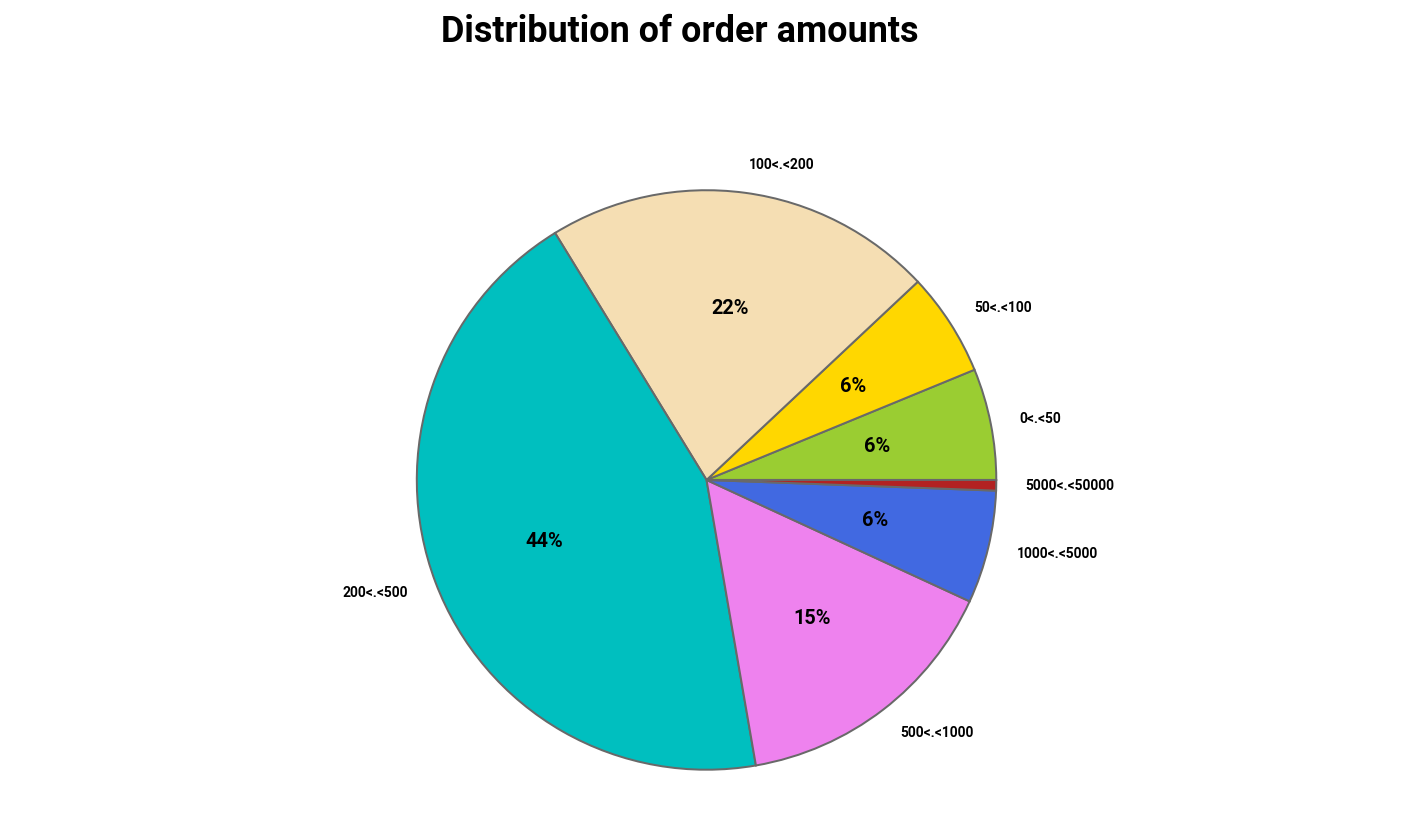

In [31]:
#____________________
# Décompte des achats
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = basket_price[(basket_price['Basket Price'] < price) &
                       (basket_price['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    count_price.append(val)
#____________________________________________
# Représentation du nombre d'achats / montant        
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}<.<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Distribution of order amounts", ha='center', fontsize = 18);

注文の大半は、比較的大きな購入に関するものであり、  〜 購入の65％は£200を超える金額となっている。


## 製品カテゴリー

製品はStockCodeを通じて一意に識別されます。
製品の断片的な説明は、Description変数で指定されます。

このセクションでは、製品をさまざまなカテゴリにグループ化するために、この後者の変数のコンテンツを使用する。


### キーワード抽出


最初のステップとして、有用であると証明される情報をDescription変数から抽出します。これを行うには、次の関数を使用します。

In [32]:
is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, colonne = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1                
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("Nb of keywords in variable '{}': {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

この関数は、データフレームを入力として受け取り、次の操作を実行して[ 説明 ]列の内容を分析します。

- 製品の説明に表示される名前（適切な、一般的な）を抽出する
- 名前ごとに、単語のルートを抽出し、この特定のルートに関連付けられた名前のセットを集約します
- 各ルートがデータフレームに表示される回数をカウントします
- 同じルートに対して複数の単語がリストされている場合、このルートに関連付けられているキーワードが最短名であると考えます（単数形/複数形のバリエーションがある場合、体系的に単数形を選択します）

分析の最初のステップは、製品のリストを取得することです。

In [290]:
df_produits = pd.DataFrame(df_initial['Description'].unique()).rename(columns = {0:'Description'})

このリストを作成したら、さまざまな製品の説明を分析するために、以前に定義した関数を使用します。

In [291]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_produits)

Nb of keywords in variable 'Description': 1484


この関数を実行すると、3つの変数が返されます。

- keywords：抽出されたキーワードのリスト
- keywords_roots：キーがキーワードのルートであり、値がそれらのルートに関連付けられた単語のリストである辞書
- count_keywords：すべての単語が使用された回数をリストする辞書

この時点で、count_keywords辞書をリストに変換し、出現順にキーワードをソートします。

In [292]:
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)

それを使用して、最も一般的なキーワードの表現を作成します。

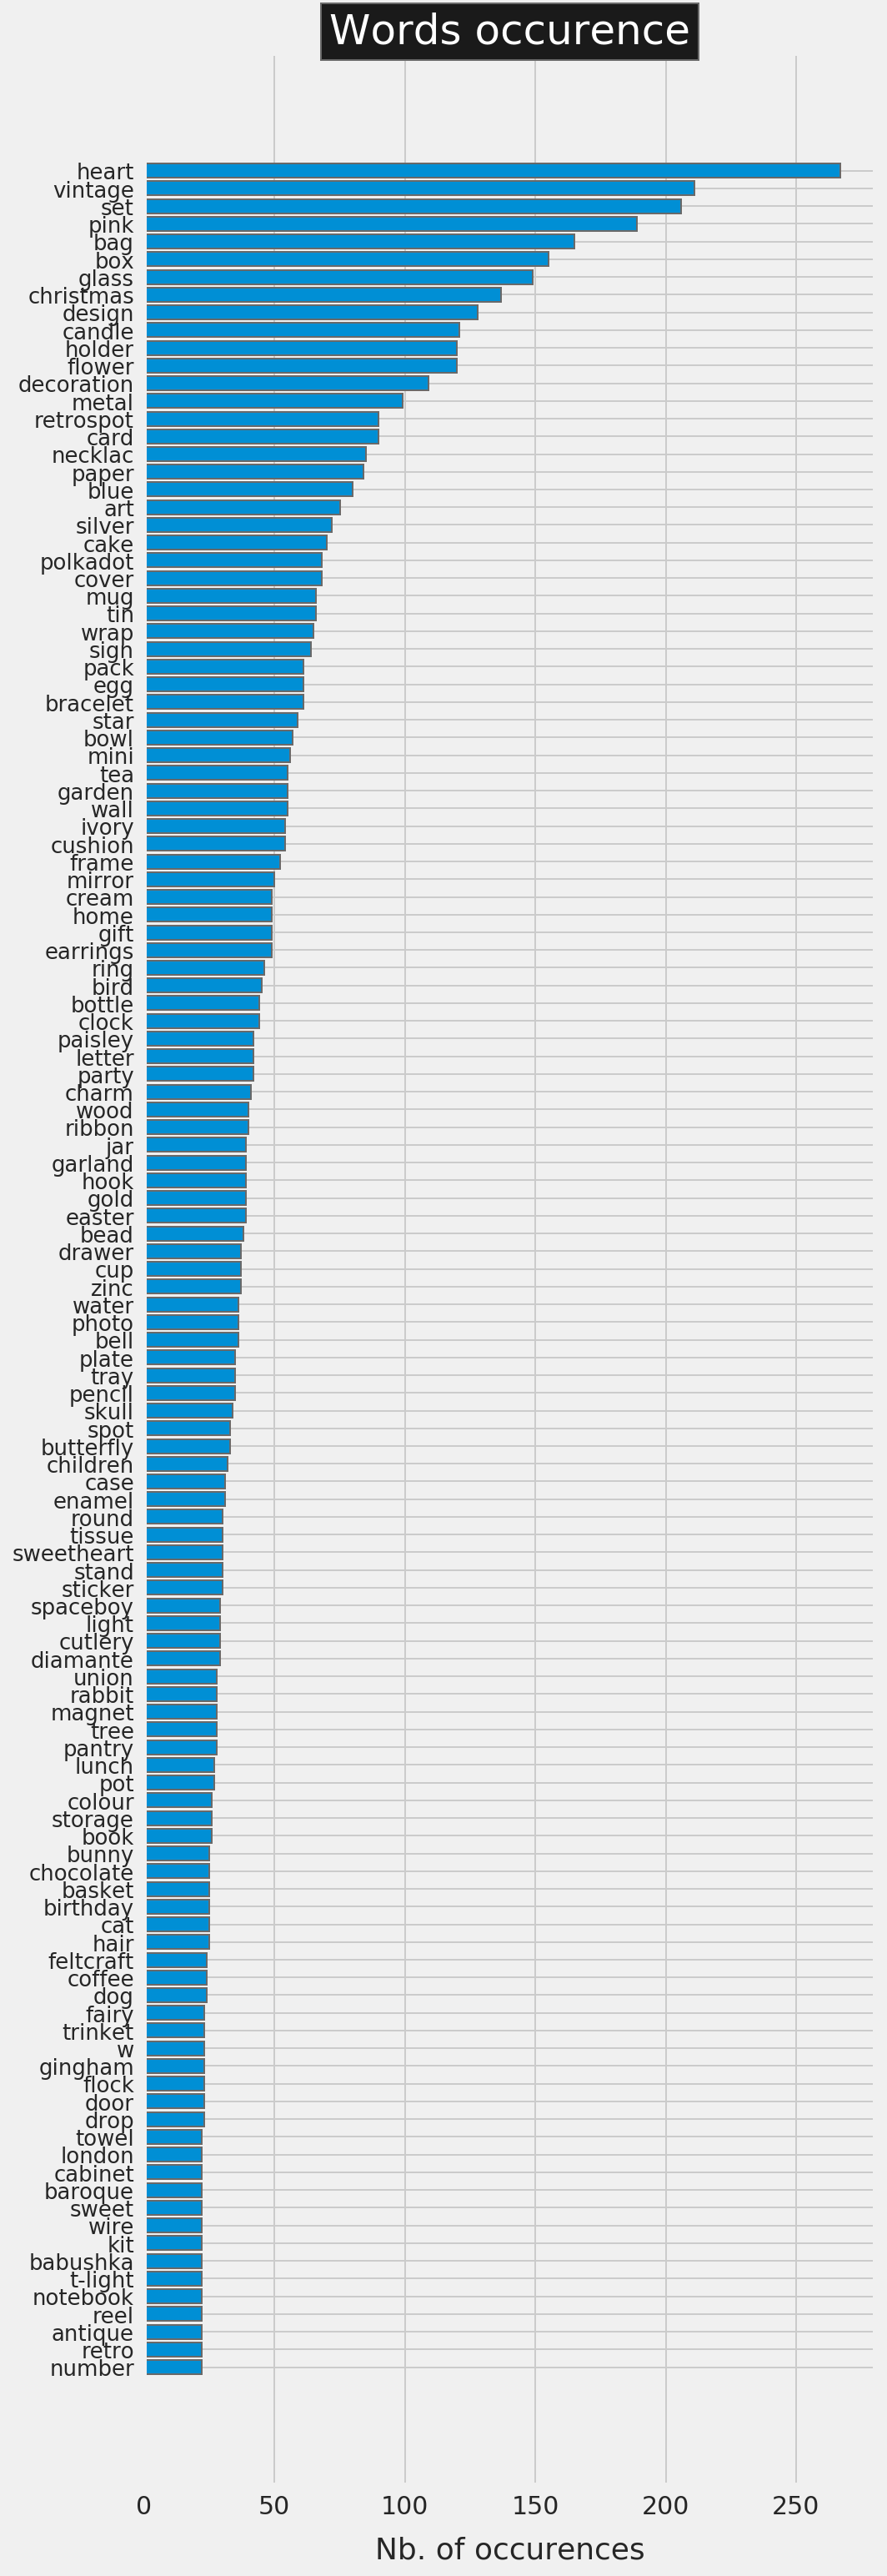

In [293]:
liste = sorted(list_products, key = lambda x:x[1], reverse = True)
#_______________________________
plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in liste[:125]]
x_axis = [k for k,i in enumerate(liste[:125])]
x_label = [i[0] for i in liste[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("Nb. of occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()
#_______________________________________________________________________________________
plt.title("Words occurence",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

___
### 3.2 Defining product categories 

製品カテゴリの定義
取得したリストには1400を超えるキーワードが含まれており、最も頻繁に使用されるキーワードは200を超える製品に含まれています。ただし、リストの内容を調べている間、一部の名前は役に立たないことに注意してください。他のものは、色などの情報を伝えません。したがって、これらの単語を後続の分析から破棄し、13回以上出現する単語のみを考慮することにしました。

In [294]:
list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])
#______________________________________________________    
list_products.sort(key = lambda x:x[1], reverse = True)
print('mots conservés:', len(list_products))

mots conservés: 193


____
#### 3.2.1 Data encoding

Now I will use these keywords to create groups of product. Firstly, I define the $X$ matrix as:

データのエンコード
次に、これらのキーワードを使用して製品のグループを作成します。まず、 バツ  マトリックスとして：

   
|   | mot 1  |  ...  | mot j  | ...  | mot N  |
|:-:|---|---|---|---|---|
| produit 1  | $a_{1,1}$  |     |   |   | $a_{1,N}$  |
| ...        |            |     | ...  |   |   |
|produit i   |    ...     |     | $a_{i,j}$    |   | ...  |
|...         |            |     |  ... |   |   |
| produit M  | $a_{M,1}$  |     |   |   | $a_{M,N}$   |

where the $a_ {i, j}$ coefficient  is 1 if the description of the product $i$ contains the word $j$, and 0 otherwise.

どこ  ai 、j  製品の説明の場合、係数は1  私  単語が含まれています  j 、それ以外の場合は0。

In [295]:
liste_produits = df_cleaned['Description'].unique()
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), liste_produits))

The $X$ matrix indicates the words contained in the description of the products using the *one-hot-encoding* principle. In practice, I have found that introducing the price range results in more balanced groups in terms of element numbers.
Hence, I add 6 extra columns to this matrix, where I indicate the price range of the products:

マトリックスは、ワンホットエンコーディングの原則を使用して製品の説明に含まれる単語を示します。実際には、価格帯を導入すると、要素数の点でよりバランスのとれたグループになることがわかりました。したがって、このマトリックスに6つの列を追加し、製品の価格帯を示します。

In [296]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    X.loc[:, col] = 0

for i, prod in enumerate(liste_produits):
    prix = df_cleaned[ df_cleaned['Description'] == prod]['UnitPrice'].mean()
    j = 0
    while prix > threshold[j]:
        j+=1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 1

適切な範囲を選択するために、さまざまなグループの製品の数を確認します。

In [297]:
print("{:<8} {:<20} \n".format('gamme', 'nb. produits') + 20*'-')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])    
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

gamme    nb. produits         
--------------------
0<.<1       964                 
1<.<2       1009                
2<.<3       673                 
3<.<5       606                 
5<.<10      470                 
.>10        156                 


____
#### 3.2.2 製品クラスターの作成

In this section, I will group the products into different classes. In the case of matrices with binary encoding, the most suitable metric for the calculation of distances is the [Hamming's metric](https://en.wikipedia.org/wiki/Distance_de_Hamming). Note that the **kmeans** method of sklearn uses a Euclidean distance that can be used, but it is not to the best choice in the case of categorical variables. However, in order to use the Hamming's metric, we need to use the [kmodes](https://pypi.python.org/pypi/kmodes/) package which is not available on the current plateform. Hence, I use the **kmeans** method even if this is not the best choice.

In order to define (approximately) the number of clusters that best represents the data, I use the silhouette score:

このセクションでは、製品を異なるクラスにグループ化します。バイナリエンコーディングの行列の場合、距離の計算に最も適したメトリックは、ハミングのメトリックです。sklearnのkmeansメソッドは、使用可能なユークリッド距離を使用しますが、カテゴリ変数の場合には最適な選択ではないことに注意してください。ただし、ハミングのメトリックを使用するには、現在のプレートフォームでは利用できないkmodesパッケージを使用する必要があります。したがって、最良の選択ではない場合でも、kmeansメソッドを使用します。

データを最もよく表すクラスターの数を（およそ）定義するために、シルエットスコアを使用します。

In [298]:
matrix = X.as_matrix()
for n_clusters in range(3,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.10158702596012364
For n_clusters = 4 The average silhouette_score is : 0.1268004588393788
For n_clusters = 5 The average silhouette_score is : 0.14740815062347604
For n_clusters = 6 The average silhouette_score is : 0.14329241182453895
For n_clusters = 7 The average silhouette_score is : 0.14815857682753922
For n_clusters = 8 The average silhouette_score is : 0.15342109568144105
For n_clusters = 9 The average silhouette_score is : 0.13193352606233583


In practice, the scores obtained above can be considered equivalent since, depending on the run, scores of $ 0.1 \pm 0.05 $ will be obtained for all clusters with `n_clusters` $> $ 3 (we obtain slightly lower scores for the first cluster). On the other hand, I found that beyond 5 clusters, some clusters contained very few elements. I therefore choose to separate the dataset into 5 clusters. In order to ensure a good classification at every run of the notebook, I iterate untill we obtain the best possible silhouette score, which is, in the present case, around 0.15:

実際には、実行に応じて、上記のスコアは同等であると見なすことができます。  0.1 ± 0.05  ですべてのクラスターについて取得されます n_clusters  > 3（最初のクラスターでわずかに低いスコアを取得します）。一方、5つのクラスターを超えると、一部のクラスターに含まれる要素が非常に少ないことがわかりました。したがって、データセットを5つのクラスターに分けることにしました。ノートブックを実行するたびに適切な分類を確保するために、可能な限り最高のシルエットスコアを取得するまで繰り返します。このスコアは、現在の場合、約0.15です。

#### シルエット分析ではクラスタ内のサンプルがどの程度密になっているか（凝集度）の目安となるグラフからkを設定する方法。


①クラスタ内部のサンプルの凝集度a(i)a(i)を計算。

②クラスタ同士の乖離度b(i)b(i)を計算。

③クラスタの凝集度と乖離度の差を、それらの内大きい法で割り、シルエット係数を得る。

シルエット図は各バーの縦幅がクラスタ内のサンプル数、横軸自体がシルエット係数を表す。
シルエット係数が平均以上であるサンプルが多く、また各バーの縦幅が等しければ、同数の分割ができていることを表す。

つまり、kを変化させながら、シルエット図の各バーの縦幅が同じくらいになっているかどうかを確認し、同じくらいになっていれば均等に分割ができていることが分かる。

https://qiita.com/ironball/items/5d0fb291c535a1e6037f

In [299]:
n_clusters = 5
silhouette_avg = -1
while silhouette_avg < 0.145:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    
    #km = kmodes.KModes(n_clusters = n_clusters, init='Huang', n_init=2, verbose=0)
    #clusters = km.fit_predict(matrix)
    #silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 5 The average silhouette_score is : 0.14551915467116125


___
#### 3.2.3  Characterizing the content of clusters

クラスターのコンテンツの特性化
すべてのクラスの要素の数を確認します。

In [300]:
pd.Series(clusters).value_counts()

1    1114
3    1009
2     673
0     606
4     476
dtype: int64


** a / _Silhouette intra-cluster score_ **

In order to have an insight on the quality of the classification, we can represent the silhouette scores of each element of the different clusters. This is the purpose of the next figure which is taken from the [sklearn documentation](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html):

a / Silhouetteクラスター内スコア

分類の品質に関する洞察を得るために、異なるクラスターの各要素のシルエットスコアを表すことができます。これは、sklearnのドキュメントから取得した次の図の目的です。

In [301]:
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
    #____________________________
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        #___________________________________________________________________________________
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.8)
        #____________________________________________________________________
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))
        #______________________________________
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  

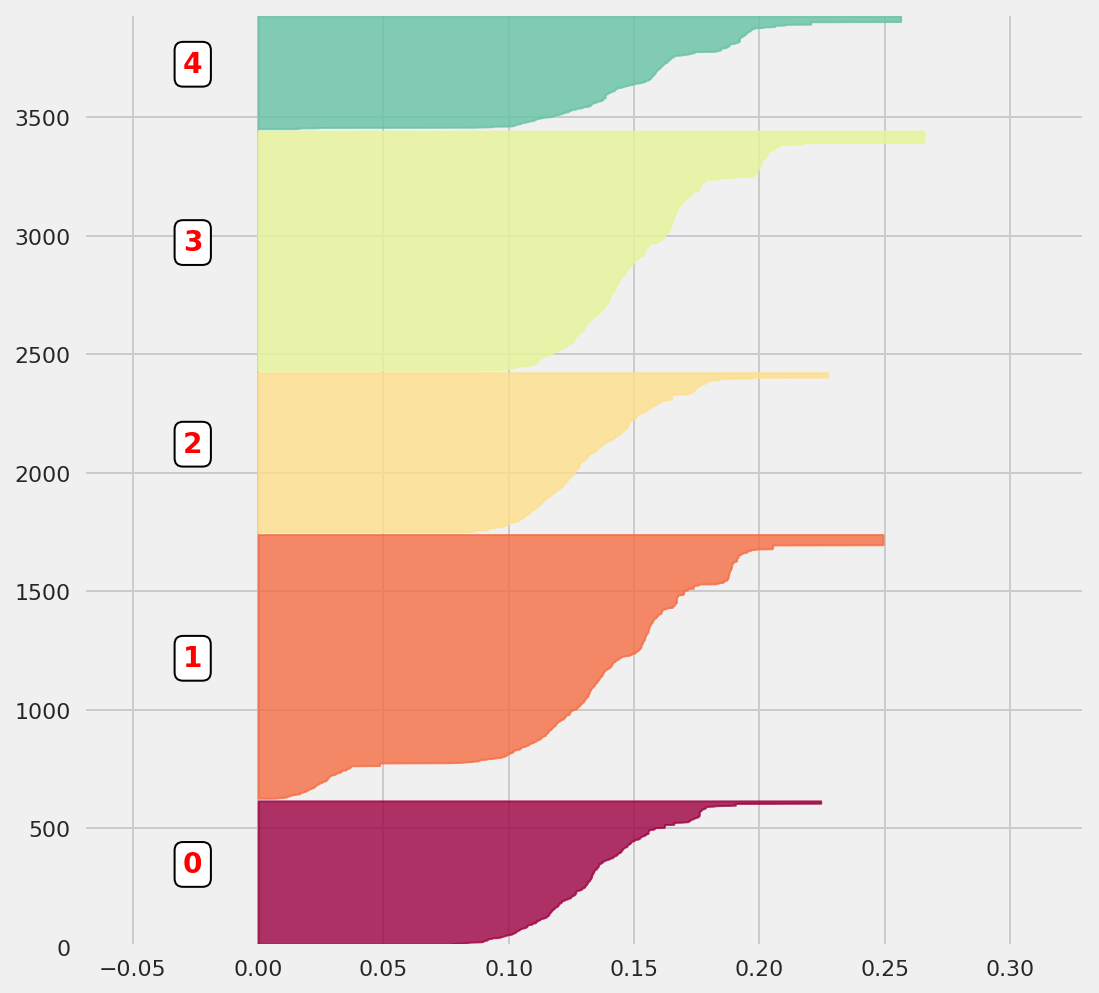

In [302]:
#____________________________________
# define individual silouhette scores
sample_silhouette_values = silhouette_samples(matrix, clusters)
#__________________
# and do the graph
graph_component_silhouette(n_clusters, [-0.07, 0.33], len(X), sample_silhouette_values, clusters)

** b/ _Word Cloud_**

Now we can have a look at the type of objects that each cluster represents. In order to obtain a global view of their contents, I determine which keywords are the most frequent in each of them

b / ワードクラウド

これで、各クラスターが表すオブジェクトのタイプを確認できます。コンテンツのグローバルビューを取得するために、各キーワードで最も頻繁に使用されるキーワードを特定します

In [303]:
liste = pd.DataFrame(liste_produits)
liste_words = [word for (word, occurence) in list_products]

occurence = [dict() for _ in range(n_clusters)]

for i in range(n_clusters):
    liste_cluster = liste.loc[clusters == i]
    for word in liste_words:
        if word in ['art', 'set', 'heart', 'pink', 'blue', 'tag']: continue
        occurence[i][word] = sum(liste_cluster.loc[:, 0].str.contains(word.upper()))

and I output the result as wordclouds:

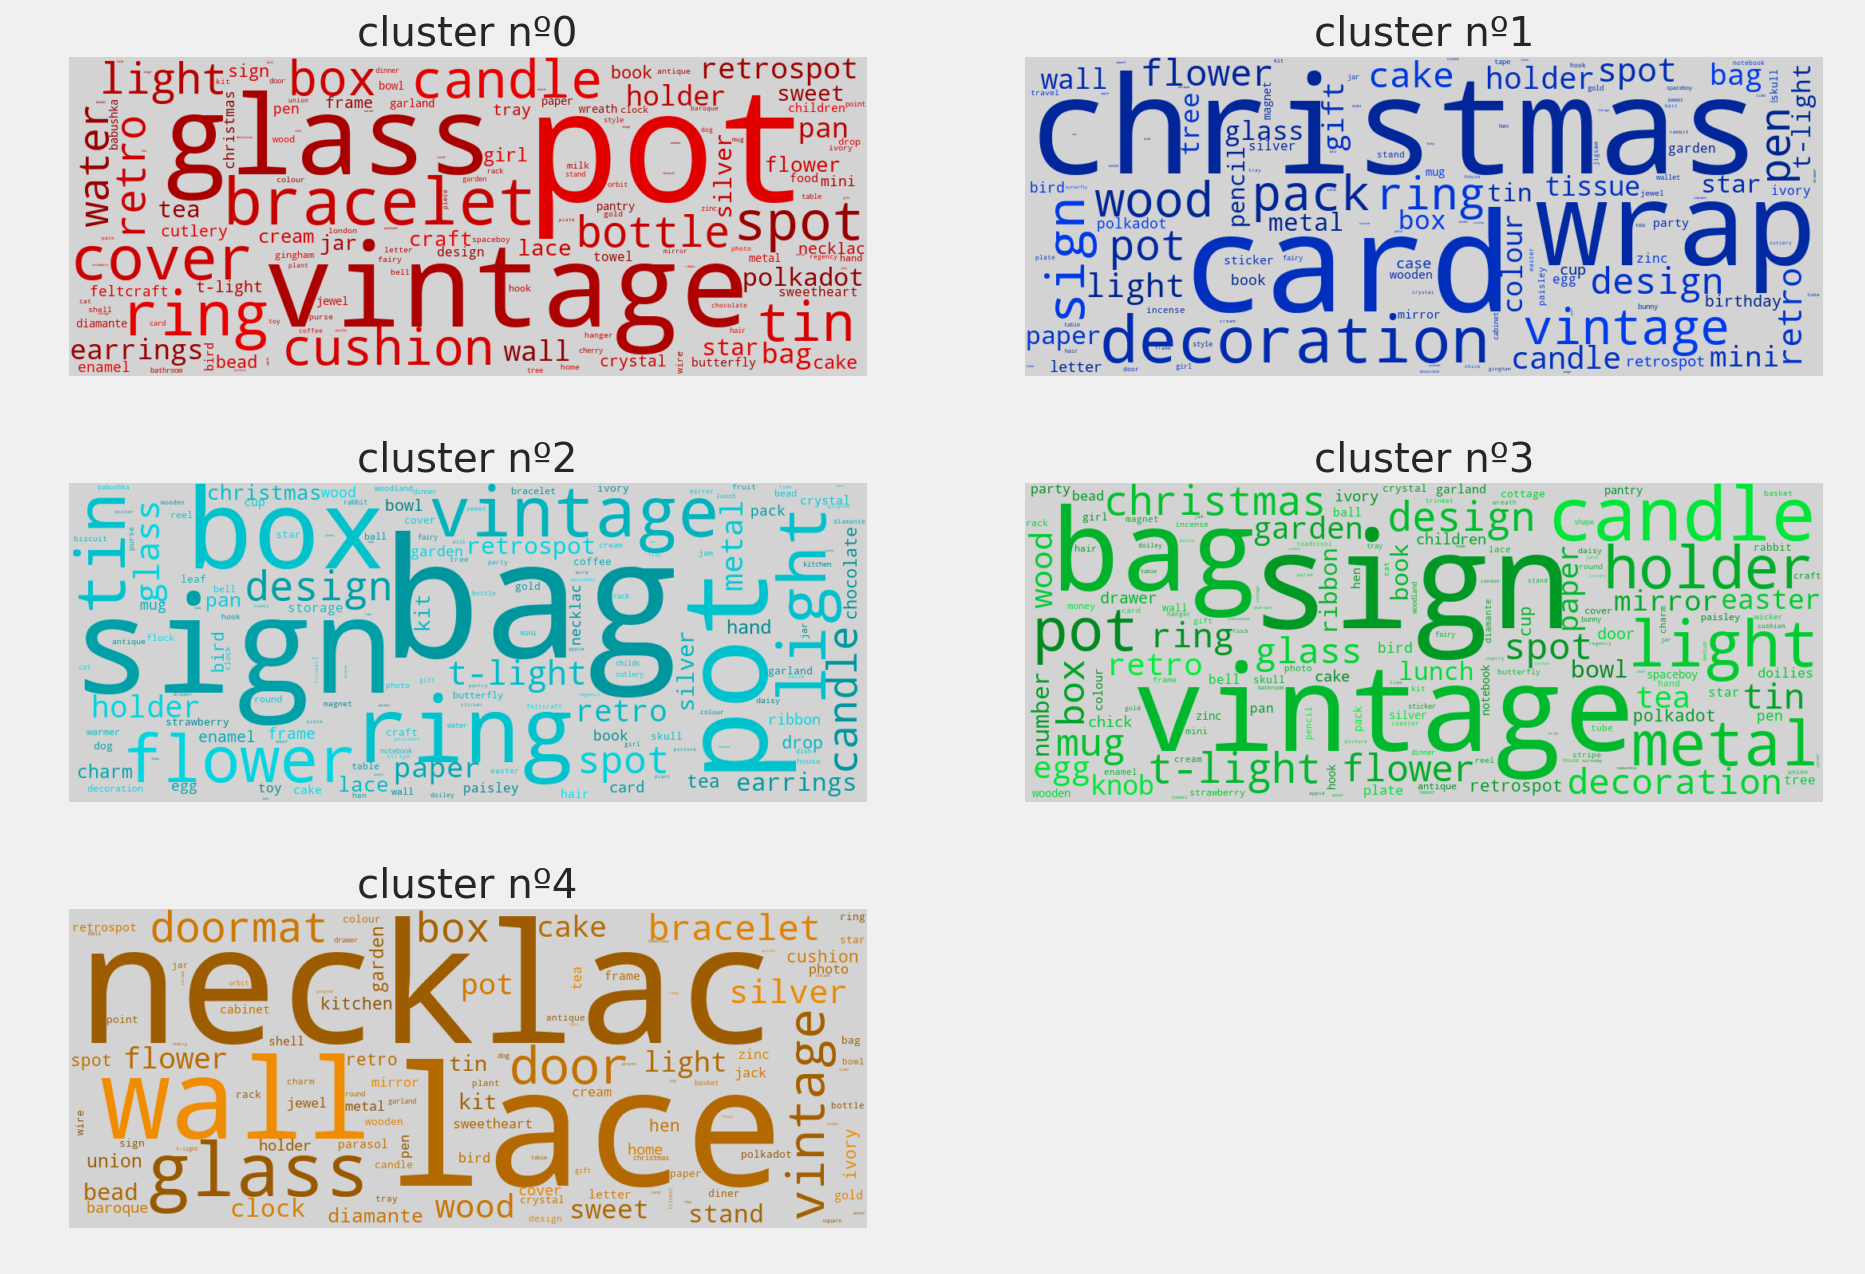

In [304]:
#________________________________________________________________________
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)
#________________________________________________________________________
def make_wordcloud(liste, increment):
    ax1 = fig.add_subplot(4,2,increment)
    words = dict()
    trunc_occurences = liste[0:150]
    for s in trunc_occurences:
        words[s[0]] = s[1]
    #________________________________________________________
    wordcloud = WordCloud(width=1000,height=400, background_color='lightgrey', 
                          max_words=1628,relative_scaling=1,
                          color_func = random_color_func,
                          normalize_plurals=False)
    wordcloud.generate_from_frequencies(words)
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')
    plt.title('cluster nº{}'.format(increment-1))
#________________________________________________________________________
fig = plt.figure(1, figsize=(14,14))
color = [0, 160, 130, 95, 280, 40, 330, 110, 25]
for i in range(n_clusters):
    list_cluster_occurences = occurence[i]

    tone = color[i] # define the color of the words
    liste = []
    for key, value in list_cluster_occurences.items():
        liste.append([key, value])
    liste.sort(key = lambda x:x[1], reverse = True)
    make_wordcloud(liste, i+1)            

この表現から、たとえば、クラスターの1つにギフト（キーワード：クリスマス、パッケージ、カードなど）に関連付けることができるオブジェクトが含まれていることがわかります。別のクラスターには、豪華なアイテムとジュエリー（キーワード：ネックレス、ブレスレット、レース、シルバー、...）が含まれます。それにもかかわらず、多くの単語がさまざまなクラスタに出現することも観察できるため、それらを明確に区別することは困難です。

### C 主成分分析

これらのクラスターが本当に明確であることを保証するために、私はそれらの構成を見ます。初期行列の変数の数が多い場合、最初にPCAを実行します。

In [305]:
pca = PCA()
pca.fit(matrix)
pca_samples = pca.transform(matrix)

次に、各コンポーネントによって説明される分散の量を確認します。

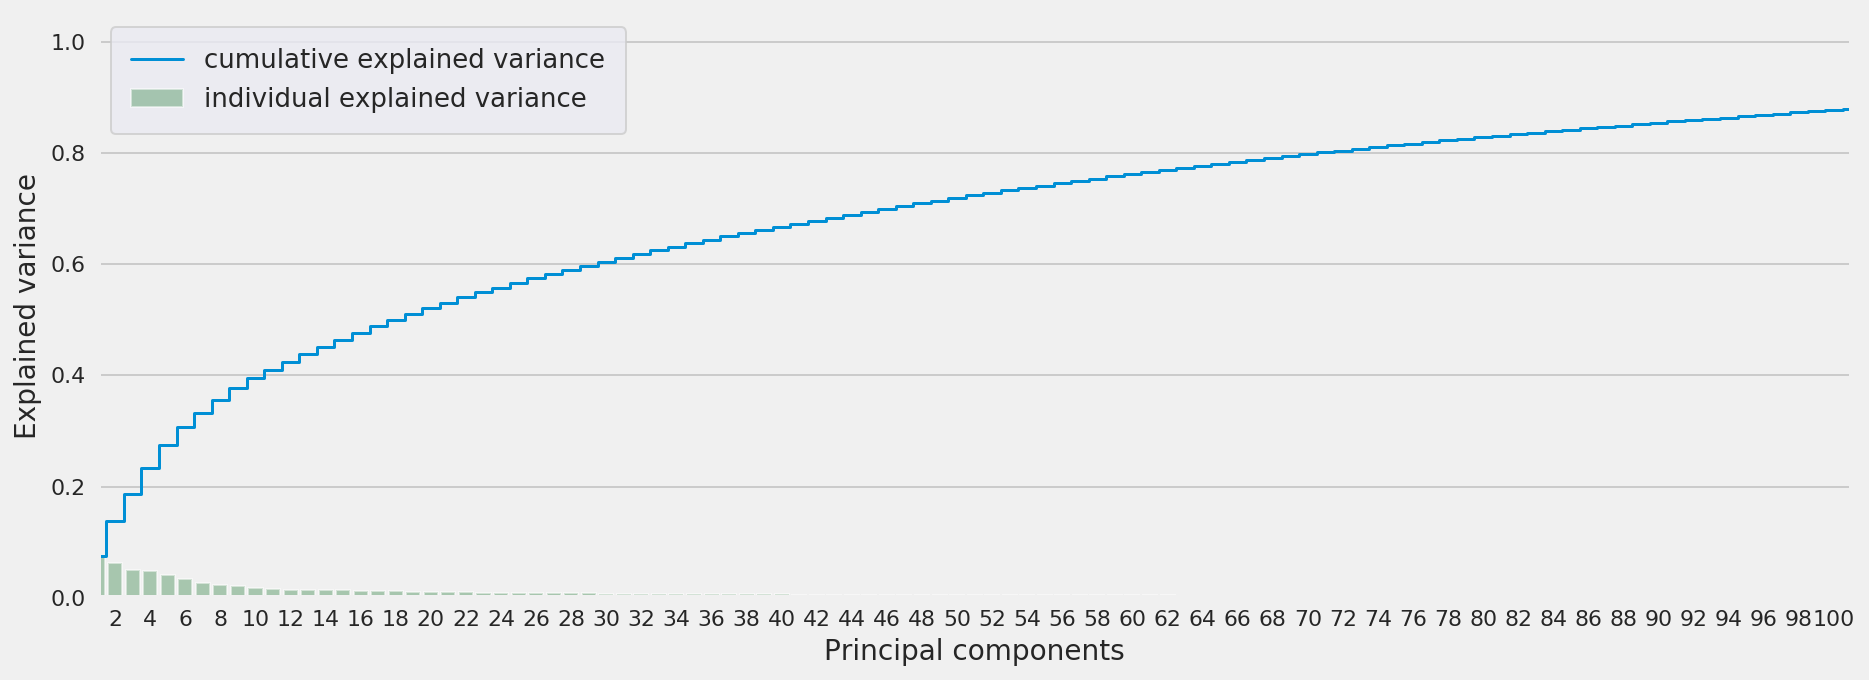

In [306]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 100)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='upper left', fontsize = 13);

We see that the number of components required to explain the data is extremely important: we need more than 100 components to explain 90% of the variance of the data. In practice, I decide to keep only a limited number of components since this decomposition is only performed to visualize the data:

データを説明するために必要なコンポーネントの数は非常に重要であることがわかります。データの分散の90％を説明するには100を超えるコンポーネントが必要です。実際には、この分解はデータを視覚化するためにのみ実行されるため、限られた数のコンポーネントのみを保持することにします。

In [307]:
pca = PCA(n_components=50)
matrix_9D = pca.fit_transform(matrix)
mat = pd.DataFrame(matrix_9D)
mat['cluster'] = pd.Series(clusters)

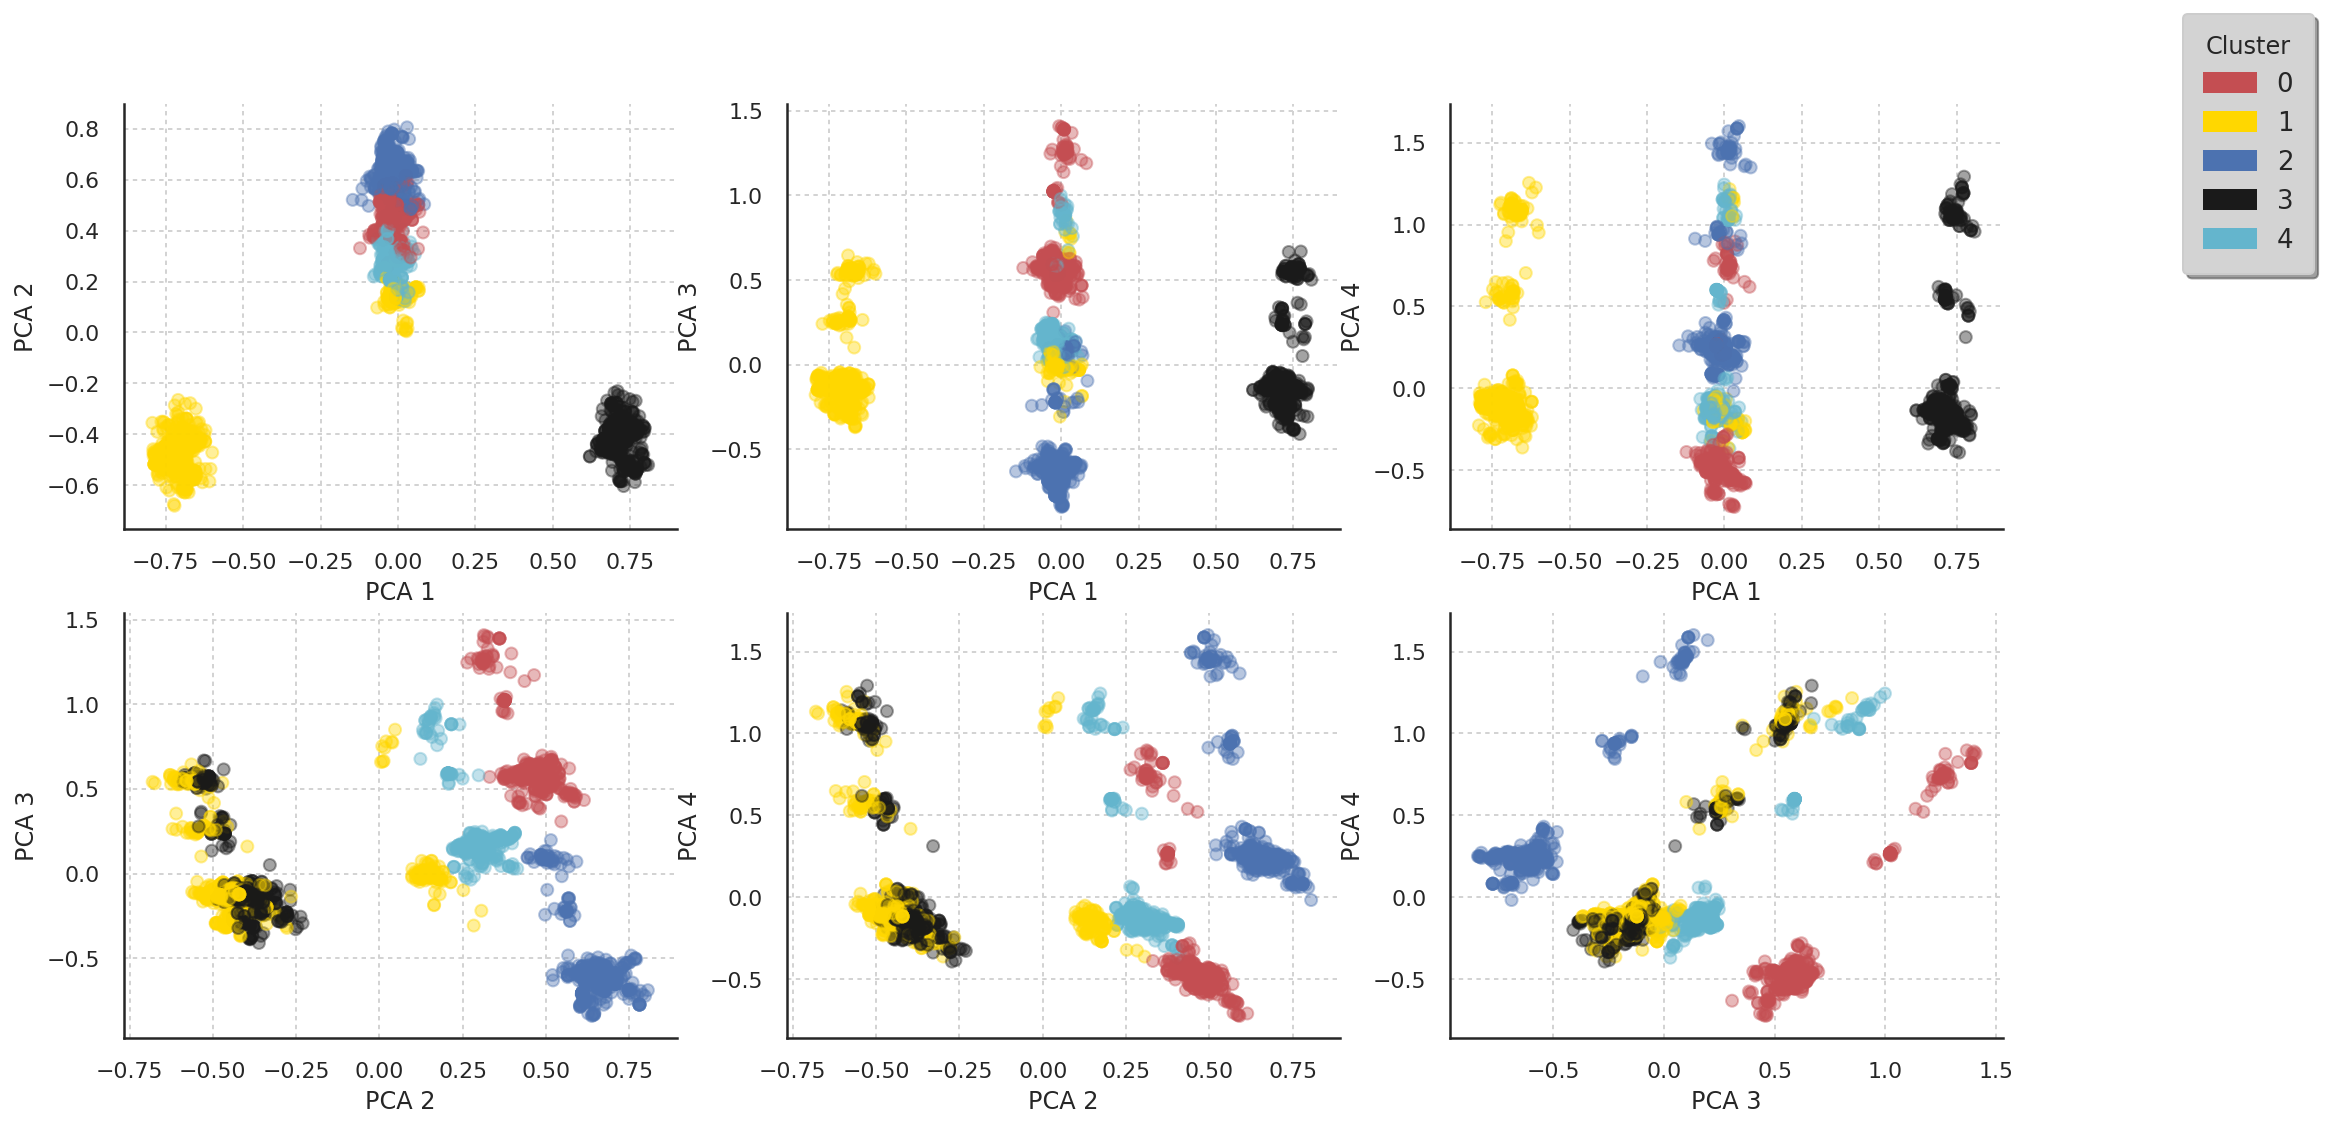

In [308]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'gold', 2:'b', 3:'k', 4:'c', 5:'g'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (15,8))
increment = 0
for ix in range(4):
    for iy in range(ix+1, 4):    
        increment += 1
        ax = fig.add_subplot(2,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.4) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 9: break
    if increment == 9: break
        
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(5):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.97), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.show()

___
## 4. 顧客カテゴリ

### 4.1 Formatting data

前のセクションでは、さまざまな製品が5つのクラスターにグループ化されていました。分析の残りを準備するための最初のステップは、この情報をデータフレームに導入することです。これを行うには、カテゴリ変数categ_productを作成します。ここで、各製品のクラスターを示します。

In [309]:
corresp = dict()
for key, val in zip (liste_produits, clusters):
    corresp[key] = val 
#__________________________________________________________________________
df_cleaned['categ_product'] = df_cleaned.loc[:, 'Description'].map(corresp)

___
#### 4.1.1 Grouping products

In a second step, I decide to create the **categ_N** variables (with $ N \in [0: 4]$) that contains the amount spent in each product category:


4.1.1製品のグループ化
2番目のステップでは、categ_N変数を作成することにします（ N∈ [ 0 ：4 ] ）各製品カテゴリで費やされた金額を含む：

In [310]:
for i in range(5):
    col = 'categ_{}'.format(i)        
    df_temp = df_cleaned[df_cleaned['categ_product'] == i]
    price_temp = df_temp['UnitPrice'] * (df_temp['Quantity'] - df_temp['QuantityCanceled'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    df_cleaned.loc[:, col] = price_temp
    df_cleaned[col].fillna(0, inplace = True)
#__________________________________________________________________________________________________
df_cleaned[['InvoiceNo', 'Description', 'categ_product', 'categ_0', 'categ_1', 'categ_2', 'categ_3','categ_4']][:5]

InvoiceNo                          Description  categ_product  categ_0  \
0    536365   WHITE HANGING HEART T-LIGHT HOLDER              2     0.00   
1    536365                  WHITE METAL LANTERN              0    20.34   
2    536365       CREAM CUPID HEARTS COAT HANGER              0    22.00   
3    536365  KNITTED UNION FLAG HOT WATER BOTTLE              0    20.34   
4    536365       RED WOOLLY HOTTIE WHITE HEART.              0    20.34   

   categ_1  categ_2  categ_3  categ_4  
0      0.0     15.3      0.0      0.0  
1      0.0      0.0      0.0      0.0  
2      0.0      0.0      0.0      0.0  
3      0.0      0.0      0.0      0.0  
4      0.0      0.0      0.0      0.0

Up to now, the information related to a single order was split over several lines of the dataframe (one line per product). I decide to collect the information related to a particular order and put in in a single entry. I therefore create a new dataframe that contains, for each order, the amount of the basket, as well as the way it is distributed over the 5 categories of products:

これまで、単一の注文に関連する情報は、データフレームの複数の行（製品ごとに1行）に分割されていました。特定の注文に関連する情報を収集し、1つのエントリに入れることにしました。そのため、注文ごとにバスケットの金額と、5つのカテゴリの製品にバスケットを配布する方法を含む新しいデータフレームを作成します。

In [311]:
#___________________________________________
# somme des achats / utilisateur & commande
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})
#____________________________________________________________
# pourcentage du prix de la commande / categorie de produit
for i in range(5):
    col = 'categ_{}'.format(i) 
    temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)[col].sum()
    basket_price.loc[:, col] = temp 
#_____________________
# date de la commande
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])
#______________________________________
# selection des entrées significatives:
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID', ascending = True)[:5]

CustomerID InvoiceNo  Basket Price  categ_0  categ_1  categ_2  categ_3  \
1      12347    537626        711.79   293.35    23.40    83.40    187.2   
2      12347    542237        475.39   169.20   122.59    53.10    130.5   
3      12347    549222        636.25   115.00   119.25    71.10    330.9   
4      12347    556201        382.52   168.76    41.40    78.06     74.4   
5      12347    562032        584.91   158.16    99.55   119.70    109.7   

   categ_4                   InvoiceDate  
1   124.44 2010-12-07 14:57:00.000001024  
2     0.00 2011-01-26 14:29:59.999999744  
3     0.00 2011-04-07 10:42:59.999999232  
4    19.90 2011-06-09 13:01:00.000000256  
5    97.80 2011-08-02 08:48:00.000000000

#### 4.1.2 Separation of data over time

The dataframe `basket_price` contains information for a period of 12 months. Later, one of the objectives will be to develop a model capable of characterizing and anticipating the habits of the customers visiting the site and this, from their first visit. In order to be able to test the model in a realistic way, I split the data set by retaining the first 10 months to develop the model and the following two months to test it:

4.1.2経時的なデータの分離
データフレームにbasket_priceは、12か月間の情報が含まれています。後に、目的の1つは、サイトを訪問する顧客の習慣を特徴づけ、予測できるモデルを開発することです。モデルを現実的な方法でテストできるようにするために、モデルを開発するための最初の10か月とテストするための次の2か月を保持して、データセットを分割しました。

In [312]:
print(basket_price['InvoiceDate'].min(), '->',  basket_price['InvoiceDate'].max())

2010-12-01 08:26:00 -> 2011-12-09 12:50:00


In [313]:
set_entrainement = basket_price[basket_price['InvoiceDate'] < datetime.date(2011,10,1)]
set_test         = basket_price[basket_price['InvoiceDate'] >= datetime.date(2011,10,1)]
basket_price = set_entrainement.copy(deep = True)

____
#### 4.1.3 Consumer Order Combinations

In a second step, I group together the different entries that correspond to the same user. I thus determine the number of purchases made by the user, as well as the minimum, maximum, average amounts and the total amount spent during all the visits:

4.1.3消費者注文の組み合わせ
2番目のステップでは、同じユーザーに対応するさまざまなエントリをグループ化します。このように、ユーザーが行った購入数、およびすべての訪問中に費やした最小、最大、平均額、合計額を決定します。

In [314]:
#________________________________________________________________
# nb de visites et stats sur le montant du panier / utilisateurs
transactions_per_user=basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()
transactions_per_user.sort_values('CustomerID', ascending = True)[:5]

CustomerID  count     min     max        mean      sum    categ_0  \
0      12347      5  382.52  711.79  558.172000  2790.86  32.408290   
1      12348      4  227.44  892.80  449.310000  1797.24   0.000000   
2      12350      1  334.40  334.40  334.400000   334.40   0.000000   
3      12352      6  144.35  840.30  345.663333  2073.98  15.711338   
4      12353      1   89.00   89.00   89.000000    89.00   0.000000   

     categ_1    categ_2    categ_3    categ_4  
0  14.554295  14.524555  29.836681   8.676179  
1  58.046783   0.000000  41.953217   0.000000  
2  23.654306  27.900718  48.444976   0.000000  
3  53.725205   3.370331  12.892120  14.301006  
4  44.719101  19.887640  13.033708  22.359551

Finally, I define two additional variables that give the number of days elapsed since the first purchase (** FirstPurchase **) and the number of days since the last purchase (** LastPurchase **):

最後に、私は最初の購入（日からの経過日数与える二つの追加の変数を定義FirstPurchase）と最後の購入からの日数（LastPurchaseを）：

In [315]:
last_date = basket_price['InvoiceDate'].max().date()

first_registration = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].min())
last_purchase      = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].max())

test  = first_registration.applymap(lambda x:(last_date - x.date()).days)
test2 = last_purchase.applymap(lambda x:(last_date - x.date()).days)

transactions_per_user.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['InvoiceDate']
transactions_per_user.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['InvoiceDate']

transactions_per_user[:5]

CustomerID  count     min     max        mean      sum    categ_0  \
0      12347      5  382.52  711.79  558.172000  2790.86  32.408290   
1      12348      4  227.44  892.80  449.310000  1797.24   0.000000   
2      12350      1  334.40  334.40  334.400000   334.40   0.000000   
3      12352      6  144.35  840.30  345.663333  2073.98  15.711338   
4      12353      1   89.00   89.00   89.000000    89.00   0.000000   

     categ_1    categ_2    categ_3    categ_4  LastPurchase  FirstPurchase  
0  14.554295  14.524555  29.836681   8.676179            59            297  
1  58.046783   0.000000  41.953217   0.000000             5            288  
2  23.654306  27.900718  48.444976   0.000000           240            240  
3  53.725205   3.370331  12.892120  14.301006             2            226  
4  44.719101  19.887640  13.033708  22.359551           134            134

A customer category of particular interest is that of customers who make only one purchase. One of the objectives may be, for example, to target these customers in order to retain them. In part, I find that this type of customer represents 1/3 of the customers listed:

特に関心のある顧客カテゴリは、1回だけ購入する顧客のカテゴリです。目的の1つは、たとえば、これらの顧客をターゲットにして、顧客を維持することです。一部では、このタイプの顧客はリストされている顧客の1/3を表していることがわかります

In [316]:
n1 = transactions_per_user[transactions_per_user['count'] == 1].shape[0]
n2 = transactions_per_user.shape[0]
print("nb. de clients avec achat unique: {:<2}/{:<5} ({:<2.2f}%)".format(n1,n2,n1/n2*100))

nb. de clients avec achat unique: 1445/3608  (40.05%)


___
### 4.2 顧客カテゴリの作成

#### 4.2.1 Data encoding

The dataframe `transactions_per_user` contains a summary of all the commands that were made. Each entry in this dataframe corresponds to a particular client. I use this information to characterize the different types of customers and only keep a subset of variables:

データのエンコード
データフレームにtransactions_per_userは、作成されたすべてのコマンドの要約が含まれています。このデータフレームの各エントリは、特定のクライアントに対応しています。この情報を使用して、さまざまなタイプの顧客を特徴付け、変数のサブセットのみを保持します。

In [317]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']
#_____________________________________________________________
selected_customers = transactions_per_user.copy(deep = True)
matrix = selected_customers[list_cols].as_matrix()

In practice, the different variables I selected have quite different ranges of variation and before continuing the analysis, I  create a matrix where these data are standardized:

実際には、選択したさまざまな変数の変動範囲はかなり異なり、分析を続行する前に、これらのデータが標準化されたマトリックスを作成します。

In [318]:
scaler = StandardScaler()
scaler.fit(matrix)
print('variables mean values: \n' + 90*'-' + '\n' , scaler.mean_)
scaled_matrix = scaler.transform(matrix)

variables mean values: 
------------------------------------------------------------------------------------------
 [  3.62 259.93 556.27 377.06  16.37  21.51  21.2   25.23  15.69]


In the following, I will create clusters of customers. In practice, before creating these clusters, it is interesting to define a base of smaller dimension allowing to describe the `scaled_matrix` matrix. In this case, I will use this base in order to create a representation of the different clusters and thus verify the quality of the separation of the different groups. I therefore perform a PCA beforehand:

以下では、顧客のクラスターを作成します。実際には、これらのクラスターを作成する前に、scaled_matrixマトリックスの記述を可能にするより小さな次元のベースを定義することは興味深いです。この場合、このクラスターを使用してさまざまなクラスターの表現を作成し、さまざまなグループの分離の品質を検証します。したがって、事前にPCAを実行します。

In [319]:
pca = PCA()
pca.fit(scaled_matrix)
pca_samples = pca.transform(scaled_matrix)

and I represent the amount of variance explained by each of the components:

そして、各コンポーネントによって説明される分散の量を表します。

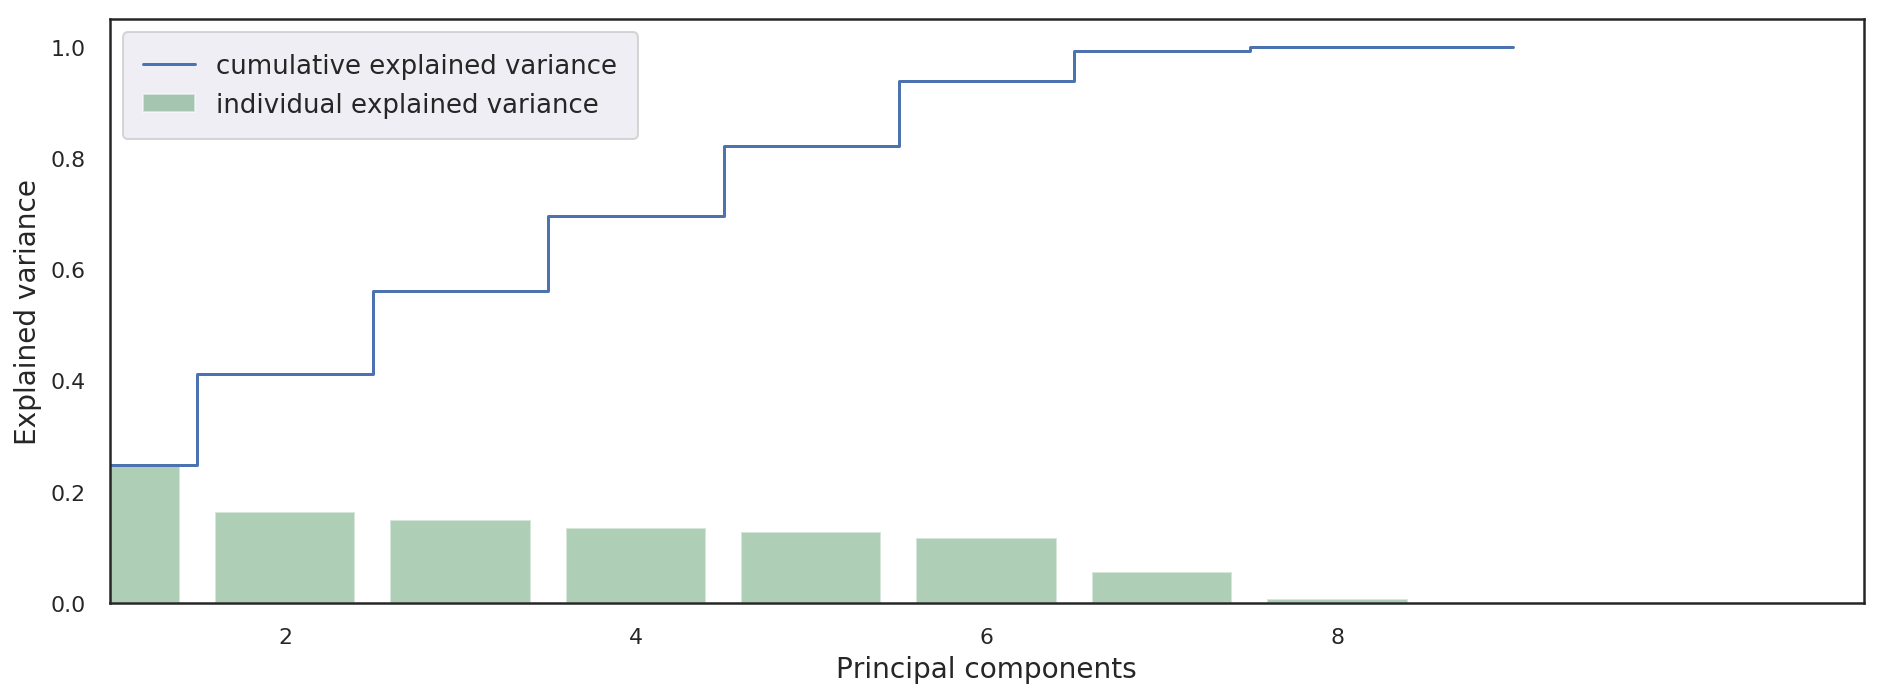

In [320]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 10)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='best', fontsize = 13);

___
#### 4.2.2 Creation of customer categories

At this point, I define clusters of clients from the standardized matrix that was defined earlier and using the `k-means` algorithm from` scikit-learn`. I choose the number of clusters based on the silhouette score and I find that the best score is obtained with 11 clusters:

顧客カテゴリの作成
この時点で、前に定義した標準化されたマトリックスからクライアントのクラスターを定義し、のk-meansアルゴリズムを使用しますscikit-learn。シルエットスコアに基づいてクラスターの数を選択すると、11のクラスターで最高のスコアが得られることがわかりました。

In [321]:
n_clusters = 11
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix)
silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
print('score de silhouette: {:<.3f}'.format(silhouette_avg))

score de silhouette: 0.214


最初に、各クラスターの顧客数を調べます。

In [322]:
pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns = ['nb. de clients']).T

4    5    3    0    7    9    2    6   10  1   8 
nb. de clients  1491  442  376  347  290  286  196  150  12  11   7

** a / _Report via the PCA_ **

There is a certain disparity in the sizes of different groups that have been created. Hence I will now try to understand the content of these clusters in order to validate (or not) this particular separation. At first, I use the result of the PCA:

/ PCA経由のレポート

作成されたさまざまなグループのサイズには、一定の格差があります。したがって、この特定の分離を検証する（または検証しない）ために、これらのクラスターの内容を理解しようとします。最初は、PCAの結果を使用します。

In [323]:
pca = PCA(n_components=6)
matrix_3D = pca.fit_transform(scaled_matrix)
mat = pd.DataFrame(matrix_3D)
mat['cluster'] = pd.Series(clusters_clients)

さまざまなクラスターの表現を作成するには：

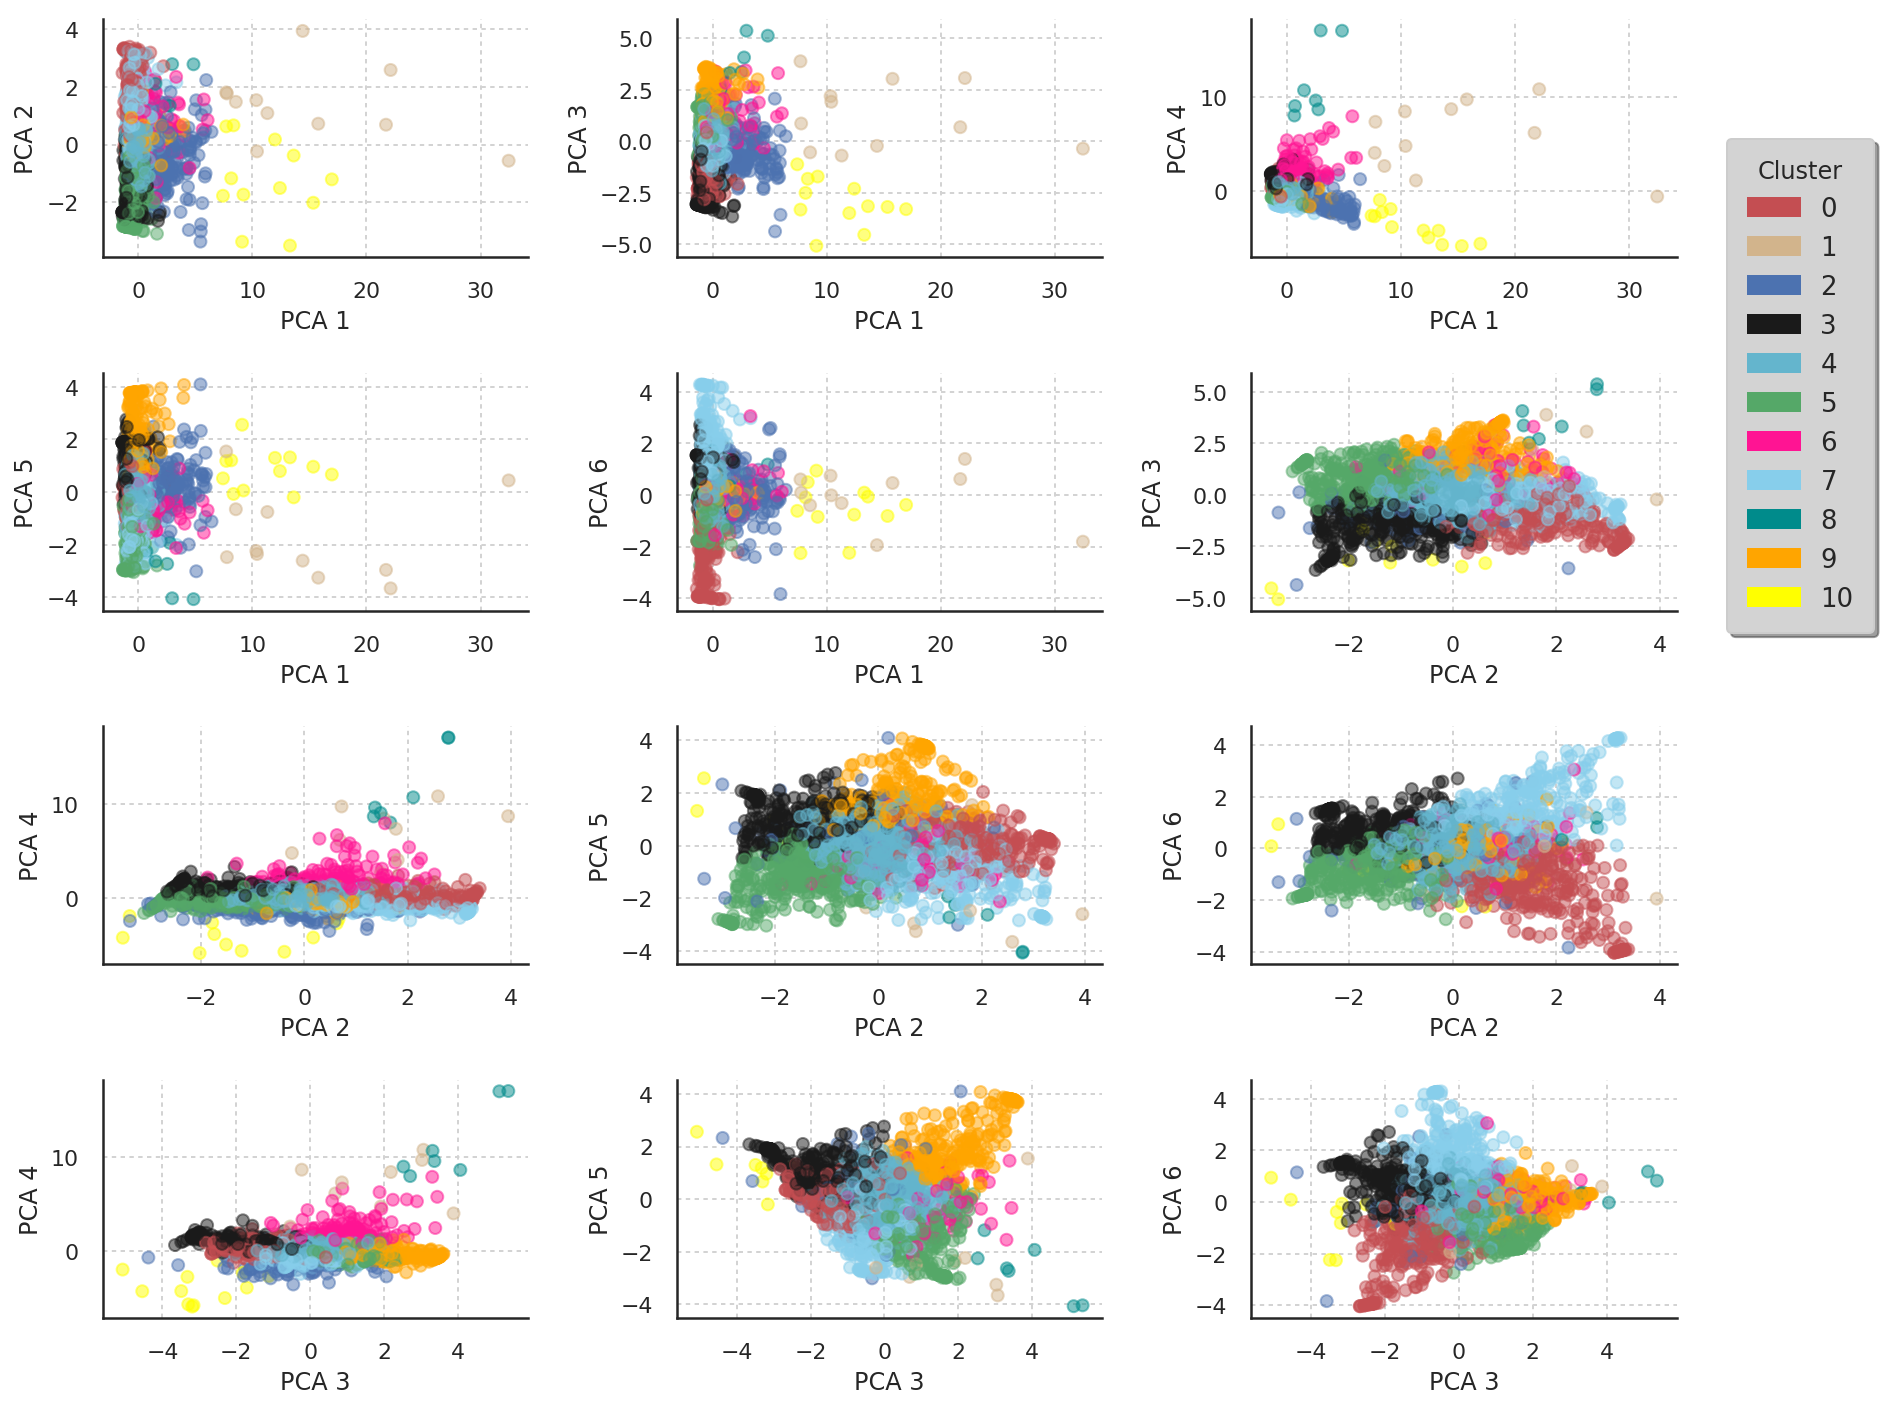

In [324]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'tan', 2:'b', 3:'k', 4:'c', 5:'g', 6:'deeppink', 7:'skyblue', 8:'darkcyan', 9:'orange',
                   10:'yellow', 11:'tomato', 12:'seagreen'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (12,10))
increment = 0
for ix in range(6):
    for iy in range(ix+1, 6):   
        increment += 1
        ax = fig.add_subplot(4,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.5) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 12: break
    if increment == 12: break
        
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(n_clusters):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.9), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.tight_layout()

From this representation, it can be seen, for example, that the first principal component allow to separate the tiniest clusters from the rest. More generally, we see that there is always a representation in which two clusters will appear to be distinct.

この表現から、たとえば、最初の主成分によって、最も小さなクラスターを残りのクラスターから分離できることがわかります。より一般的には、2つのクラスターが明確に表示される表現が常に存在することがわかります。

** b/ _Score de silhouette intra-cluster_ **

As with product categories, another way to look at the quality of the separation is to look at silouhette scores within different clusters:

クラスター内シルエットのスコア

製品カテゴリと同様に、分離の品質を調べるもう1つの方法は、異なるクラスター内のシルエットスコアを調べることです。

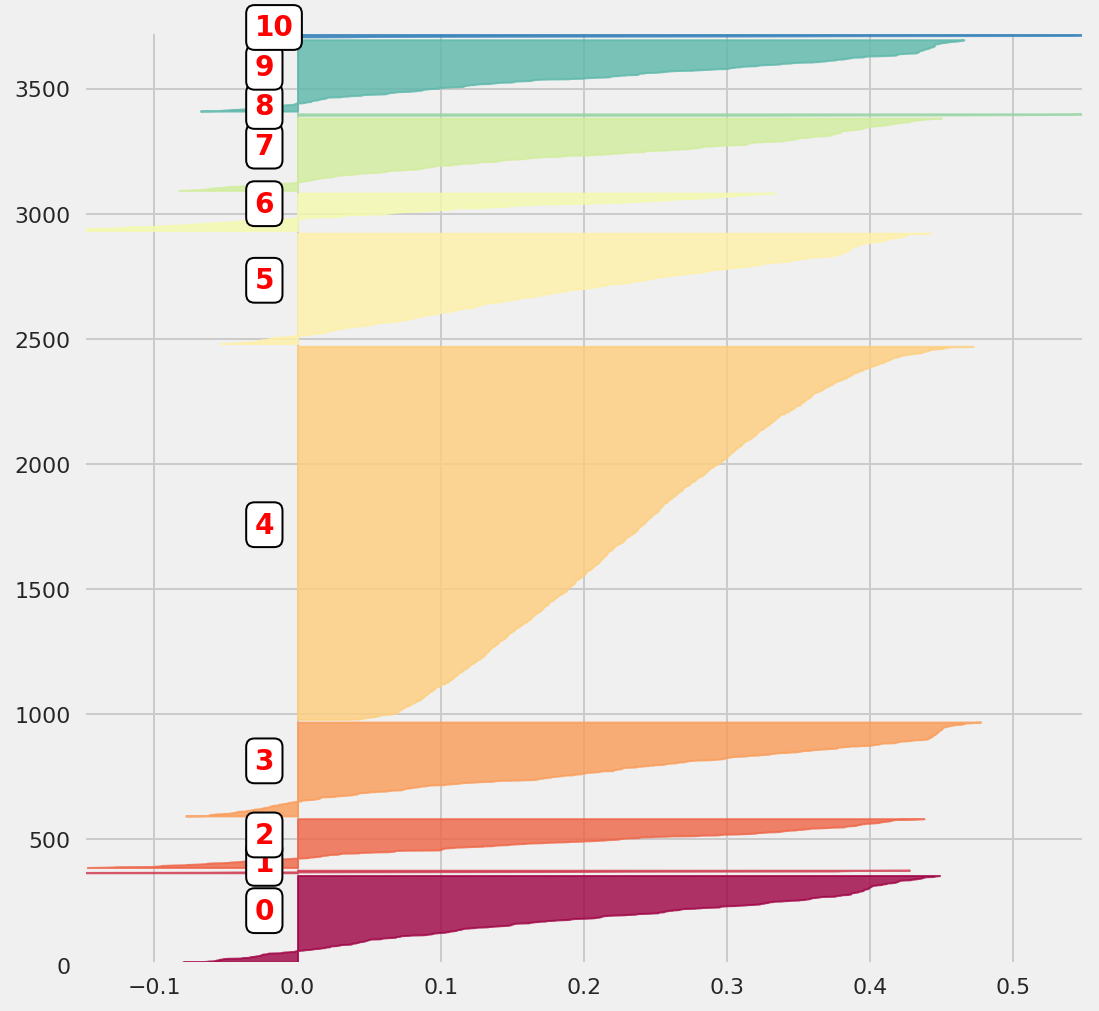

In [325]:
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
#____________________________________
# define individual silouhette scores
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
#__________________
# and do the graph
graph_component_silhouette(n_clusters, [-0.15, 0.55], len(scaled_matrix), sample_silhouette_values, clusters_clients)

** c/ _Customers morphotype_**

At this stage, I have verified that the different clusters are indeed disjoint (at least, in a global way). It remains to understand the habits of the customers in each cluster. To do so, I start by adding to the `selected_customers` dataframe a variable that defines the cluster to which each client belongs:

c / 顧客の形態型

この段階で、さまざまなクラスターが（少なくともグローバルな方法で）実際に互いに素であることを確認しました。各クラスターの顧客の習慣を理解することは残っています。そのためにselected_customersは、各クライアントが属するクラスターを定義する変数をデータフレームに追加することから始めます。

In [326]:
selected_customers.loc[:, 'cluster'] = clusters_clients

Then, I average the contents of this dataframe by first selecting the different groups of clients. This gives access to, for example, the average baskets price, the number of visits or the total sums spent by the clients of the different clusters. I also determine the number of clients in each group (variable ** size **):

次に、まずクライアントの異なるグループを選択して、このデータフレームのコンテンツを平均化します。これにより、たとえば、平均バスケット価格、訪問数、または異なるクラスターのクライアントが費やした合計にアクセスできます。また、各グループのクライアント数（可変サイズ）も決定します。

In [327]:
merged_df = pd.DataFrame()
for i in range(n_clusters):
    test = pd.DataFrame(selected_customers[selected_customers['cluster'] == i].mean())
    test = test.T.set_index('cluster', drop = True)
    test['size'] = selected_customers[selected_customers['cluster'] == i].shape[0]
    merged_df = pd.concat([merged_df, test])
#_____________________________________________________
merged_df.drop('CustomerID', axis = 1, inplace = True)
print('number of customers:', merged_df['size'].sum())

merged_df = merged_df.sort_values('sum')

number of customers: 3608


Finally, I re-organize the content of the dataframe by ordering the different clusters: first, in relation to the amount wpsent in each product category and then, according to the total amount spent:

最後に、さまざまなクラスターを順序付けて、データフレームのコンテンツを再編成します。最初に、各製品カテゴリのwpsentの量に関連して、次に、使用した合計量に応じて、

In [328]:
liste_index = []
for i in range(5):
    column = 'categ_{}'.format(i)
    liste_index.append(merged_df[merged_df[column] > 45].index.values[0])
#___________________________________
liste_index_reordered = liste_index
liste_index_reordered += [ s for s in merged_df.index if s not in liste_index]
#___________________________________________________________
merged_df = merged_df.reindex(index = liste_index_reordered)
merged_df = merged_df.reset_index(drop = False)
display(merged_df[['cluster', 'count', 'min', 'max', 'mean', 'sum', 'categ_0',
                   'categ_1', 'categ_2', 'categ_3', 'categ_4', 'size']])

cluster      count          min           max         mean           sum  \
0       7.0   2.186207   200.721862    341.785966   264.874627    676.557310   
1       3.0   2.191489   198.284574    329.212846   254.049095    606.934814   
2       9.0   2.587413   208.084441    371.371189   285.481436    805.569021   
3       5.0   2.441176   208.908439    319.899980   261.274370    661.080364   
4       0.0   2.478386   193.028963    308.191441   244.378791    621.351354   
5       4.0   3.301140   219.088673    463.941657   331.935600   1103.736440   
6       2.0   1.719388  1023.810204   1358.743628  1178.932109   2120.973015   
7      10.0   1.666667  3480.920833   3966.812500  3700.139306   5949.600000   
8       6.0  18.400000    85.466467   1528.337267   550.256001   9695.098933   
9       8.0  92.000000    10.985714   1858.250000   374.601553  34845.105714   
10      1.0  22.909091   385.752727  16513.428182  4601.666146  83676.573636   

      categ_0    categ_1    categ_2    categ_3    categ_4  size  
0   51.341711   9.937876  14.251727  13.816406  10.705690   290  
1    6.998738  60.837444   9.330723  15.289961   7.543135   376  
2    6.981819   9.481757  61.345414  14.994779   7.196231   286  
3    7.812172  15.578166  12.854965  57.886066   5.871999   442  
4   12.992090  11.637819  11.607653  11.317999  52.460700   347  
5   16.987154  20.441937  22.133743  25.493026  14.948116  1491  
6   17.029997  21.547264  21.338774  26.656765  13.427545   196  
7   15.171169  33.125675  13.322062  20.102624  18.278470    12  
8   16.390542  18.924833  25.189146  23.936027  15.580342   150  
9   13.402971  20.541454  22.527857  25.832531  17.721038     7  
10  17.813890  13.109984  28.164710  20.206767  20.704650    11

** d / _Customers morphology_ **

Finally, I created a representation of the different morphotypes. To do this, I define a class to create "Radar Charts" (which has been adapted from this [kernel](https://www.kaggle.com/yassineghouzam/don-t-know-why-employees-leave -read-this)):

d / 顧客の形態

最後に、さまざまな形態型の表現を作成しました。これを行うには、「レーダーチャート」を作成するクラスを定義します（このカーネルから適応されています）。

In [329]:
def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]

class RadarChart():
    def __init__(self, fig, location, sizes, variables, ranges, n_ordinate_levels = 6):

        angles = np.arange(0, 360, 360./len(variables))

        ix, iy = location[:] ; size_x, size_y = sizes[:]
        
        axes = [fig.add_axes([ix, iy, size_x, size_y], polar = True, 
        label = "axes{}".format(i)) for i in range(len(variables))]

        _, text = axes[0].set_thetagrids(angles, labels = variables)
        
        for txt, angle in zip(text, angles):
            if angle > -1 and angle < 181:
                txt.set_rotation(angle - 90)
            else:
                txt.set_rotation(angle - 270)
        
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid("off")
        
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i],num = n_ordinate_levels)
            grid_label = [""]+["{:.0f}".format(x) for x in grid[1:-1]]
            ax.set_rgrids(grid, labels = grid_label, angle = angles[i])
            ax.set_ylim(*ranges[i])
        
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
                
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)
        
    def title(self, title, *args, **kw):
        self.ax.text(0.9, 1, title, transform = self.ax.transAxes, *args, **kw)


This allows to have a global view of the content of each cluster:

これにより、各クラスターのコンテンツをグローバルに表示できます。

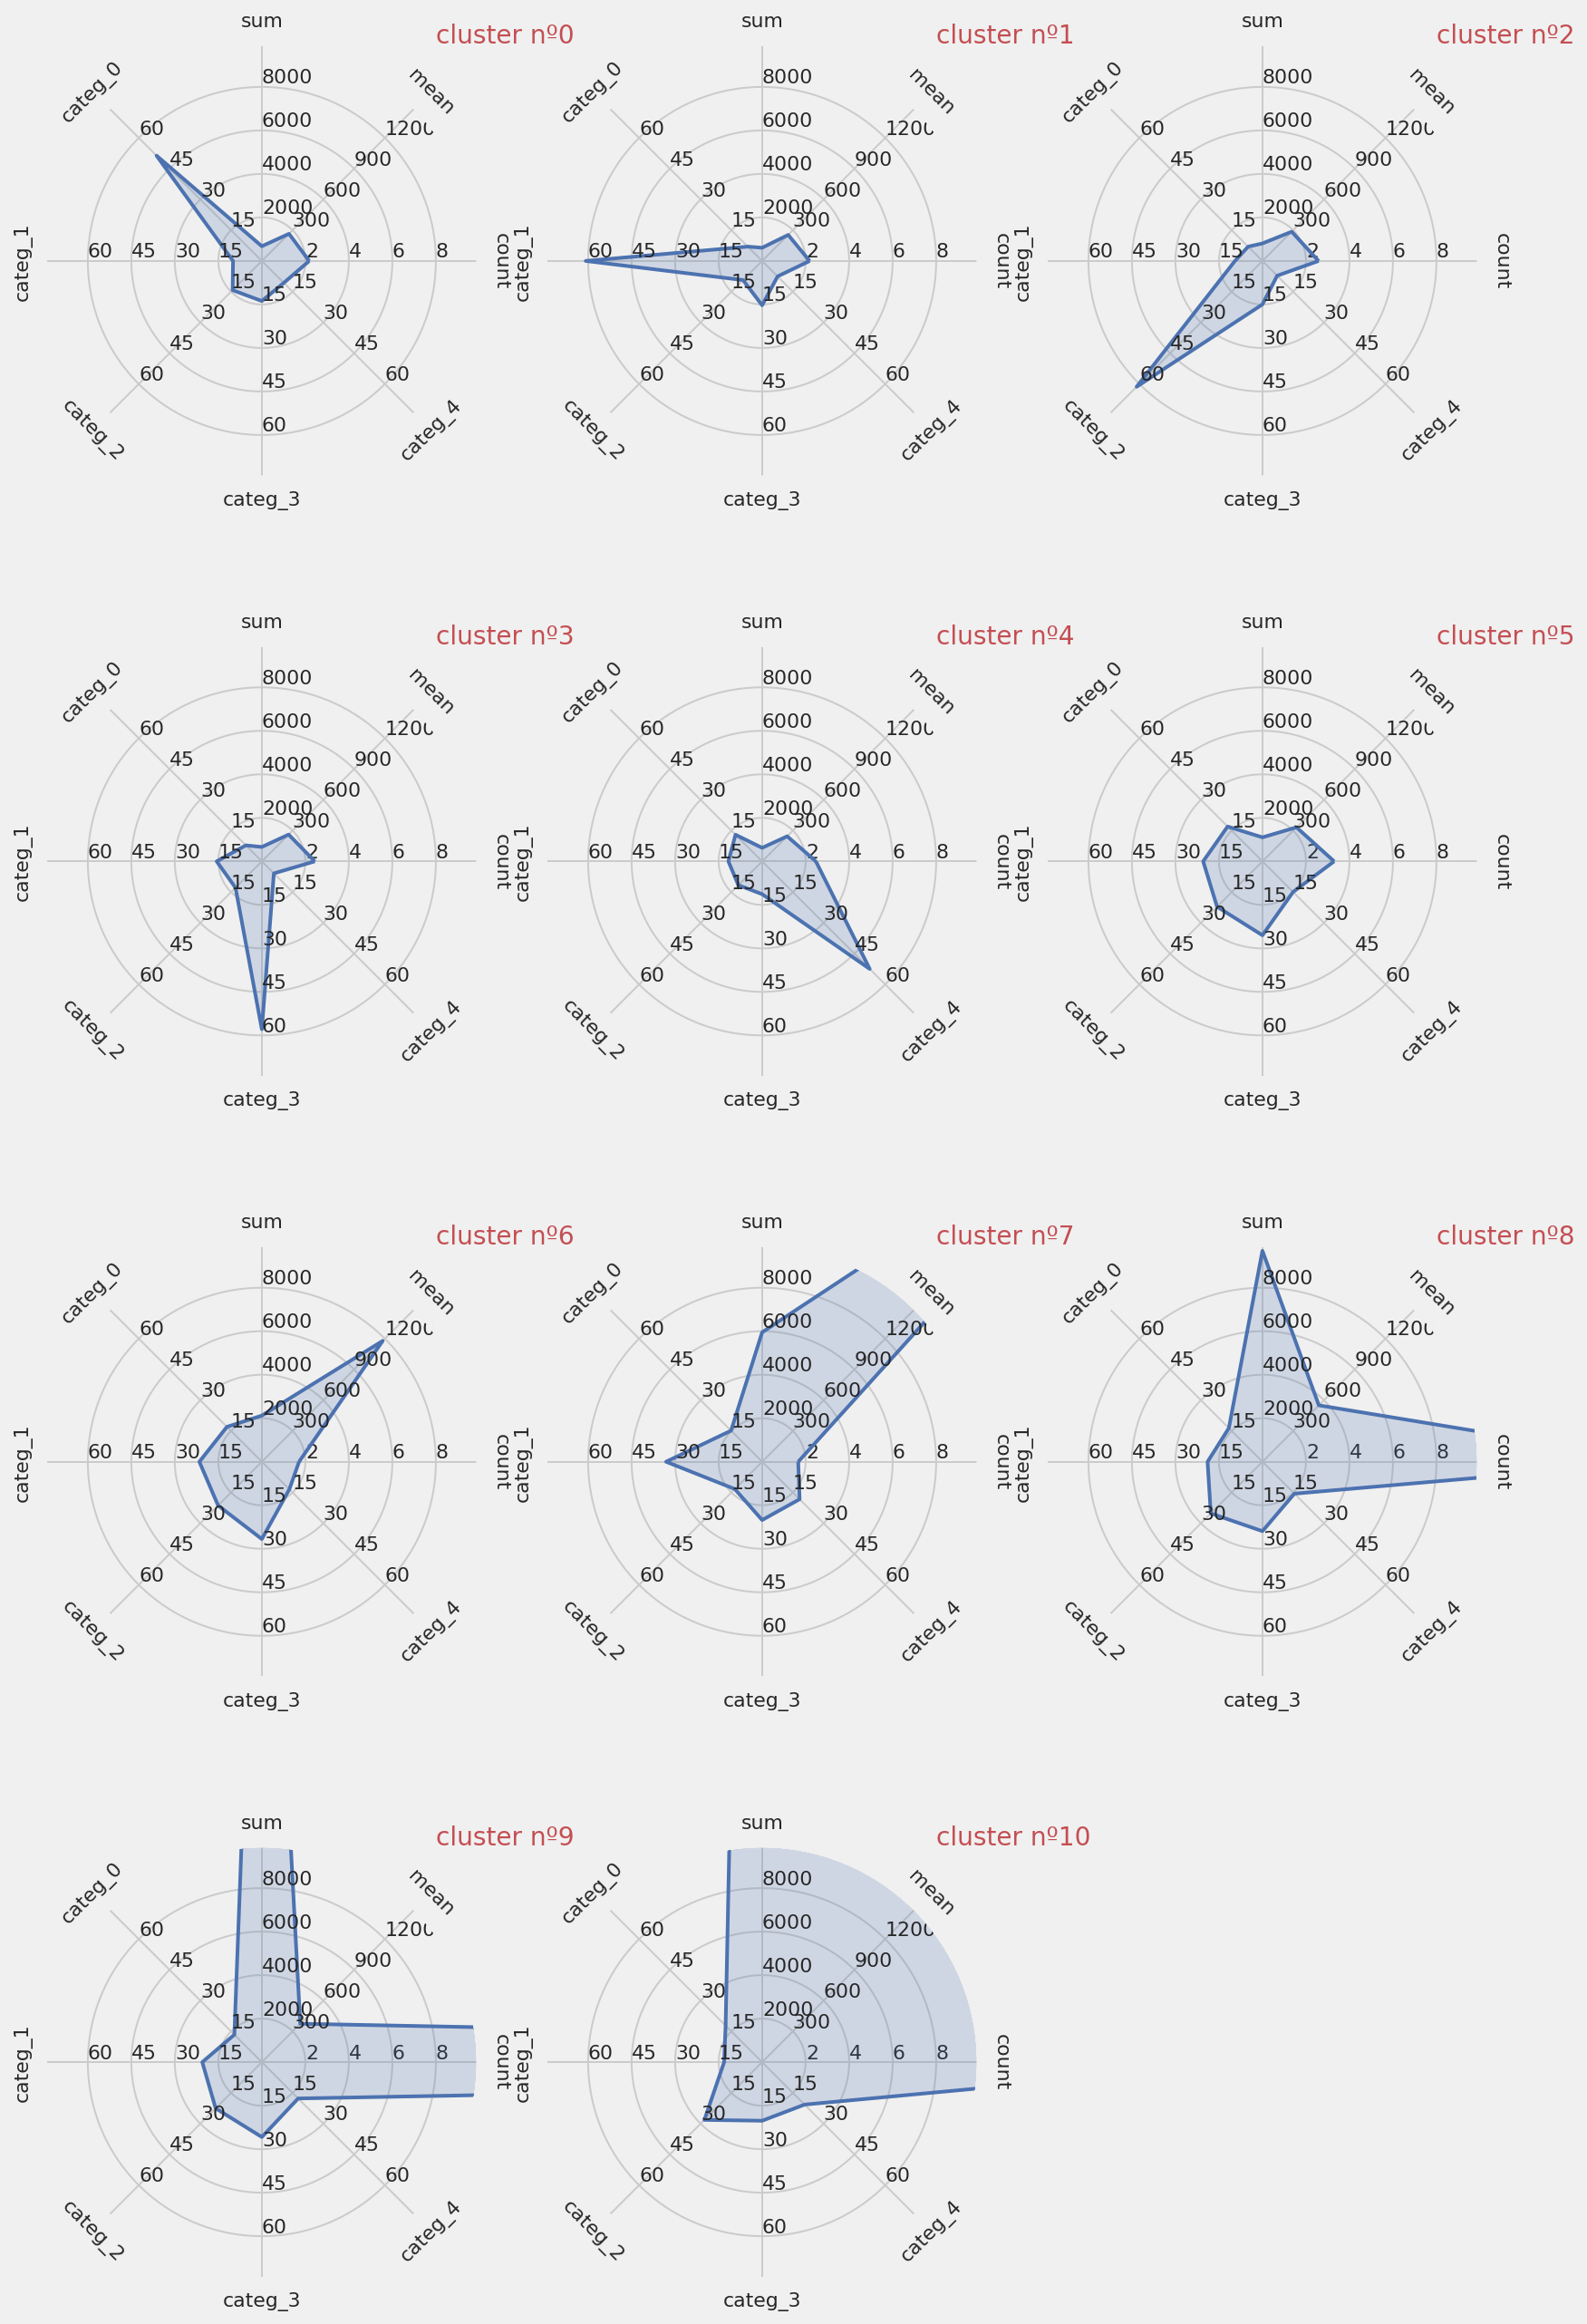

In [330]:
fig = plt.figure(figsize=(10,12))

attributes = ['count', 'mean', 'sum', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
ranges = [[0.01, 10], [0.01, 1500], [0.01, 10000], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75]]
index  = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

n_groups = n_clusters ; i_cols = 3
i_rows = n_groups//i_cols
size_x, size_y = (1/i_cols), (1/i_rows)

for ind in range(n_clusters):
    ix = ind%3 ; iy = i_rows - ind//3
    pos_x = ix*(size_x + 0.05) ; pos_y = iy*(size_y + 0.05)            
    location = [pos_x, pos_y]  ; sizes = [size_x, size_y] 
    #______________________________________________________
    data = np.array(merged_df.loc[index[ind], attributes])    
    radar = RadarChart(fig, location, sizes, attributes, ranges)
    radar.plot(data, color = 'b', linewidth=2.0)
    radar.fill(data, alpha = 0.2, color = 'b')
    radar.title(title = 'cluster nº{}'.format(index[ind]), color = 'r')
    ind += 1 

It can be seen, for example, that the first 5 clusters correspond to a strong preponderance of purchases in a particular category of products. Other clusters will differ from basket averages (** mean **), the total sum spent by the clients (** sum **) or the total number of visits made (** count **).

たとえば、最初の5つのクラスターは、製品の特定のカテゴリでの購入の強い優位性に対応していることがわかります。他のクラスターは、バスケット平均（平均）、クライアントが費やした合計（合計）、または訪問の合計数（カウント）とは異なります。

____
## 顧客クラス分類

In this part, the objective will be to adjust a classifier that will classify consumers in the different client categories that were established in the previous section. The objective is to make this classification possible at the first visit. To fulfill this objective, I will test several classifiers implemented in `scikit-learn`. First, in order to simplify their use, I define a class that allows to interface several of the functionalities common to these different classifiers: 

このパートの目的は、前のセクションで確立されたさまざまなクライアントカテゴリで消費者を分類する分類子を調整することです。目的は、最初の訪問時にこの分類を可能にすることです。この目的を達成するために、で実装されたいくつかの分類器をテストしscikit-learnます。最初に、それらの使用を簡素化するために、これらのさまざまな分類器に共通するいくつかの機能をインターフェースできるクラスを定義します。

In [331]:
class Class_Fit(object):
    def __init__(self, clf, params=None):
        if params:            
            self.clf = clf(**params)
        else:
            self.clf = clf()

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)
        
    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)
        
    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, self.predictions)))
        

Since the goal is to define the class to which a client belongs and this, as soon as its first visit, I only keep the variables that describe the content of the basket, and do not take into account the variables related to the frequency of visits or variations of the basket price over time:

目標はクライアントが属するクラスとこれを定義することであるため、最初の訪問と同時に、バスケットの内容を説明する変数のみを保持し、訪問の頻度に関連する変数は考慮しませんバスケット価格の経時変化：

In [332]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = selected_customers[columns]
Y = selected_customers['cluster']

最後に、データセットをトレーニング・セットとテスト・セットに分割しました。

In [333]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, train_size = 0.8)

___
### 5.1 Support Vector Machine Classifier (SVC)

The first classifier I use is the SVC classifier. In order to use it, I create an instance of the `Class_Fit` class and then call` grid_search()`. When calling this method, I provide as parameters:
- the hyperparameters for which I will seek an optimal value
- the number of folds to be used for cross-validation

サポートベクターマシン分類器（SVC）
最初に使用する分類子はSVC分類子です。それを使用するには、Class_Fitクラスのインスタンスを作成してから呼び出しますgrid_search()。このメソッドを呼び出すとき、パラメーターとして提供します。

- 最適な値を求めるハイパーパラメーター
- 交差検定に使用されるフォールドの数

In [334]:
svc = Class_Fit(clf = svm.LinearSVC)
svc.grid_search(parameters = [{'C':np.logspace(-2,2,10)}], Kfold = 5)

このインスタンスを作成したら、分類器をトレーニングデータに合わせて調整します。

In [335]:
svc.grid_fit(X = X_train, Y = Y_train)

その後、テストデータに関して予測の品質をテストできます。

In [336]:
svc.grid_predict(X_test, Y_test)

Precision: 86.15 % 


___
#### 5.1.1 Confusion matrix

The accuracy of the results seems to be correct. Nevertheless, let us remember that when the different classes were defined, there was an imbalance in size between the classes obtained. In particular, one class contains around 40% of the clients. It is therefore interesting to look at how the predictions and real values compare to the breasts of the different classes. This is the subject of the confusion matrices and to represent them, I use the code of the [sklearn documentation](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html):

5.1.1混同マトリックス
結果の精度は正しいようです。それでも、異なるクラスが定義されたときに、取得されたクラス間でサイズの不均衡があったことを思い出してください。特に、1つのクラスには約40％のクライアントが含まれます。したがって、予測と実際の値が異なるクラスの胸とどのように比較されるかを見るのは興味深いです。これは混同マトリックスの主題であり、それらを表現するために、sklearnドキュメンテーションのコードを使用します

In [337]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    #_________________________________________________
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    #_________________________________________________
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #_________________________________________________
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

from which I create the following representation:

ここから次の表現を作成します。

Confusion matrix, without normalization


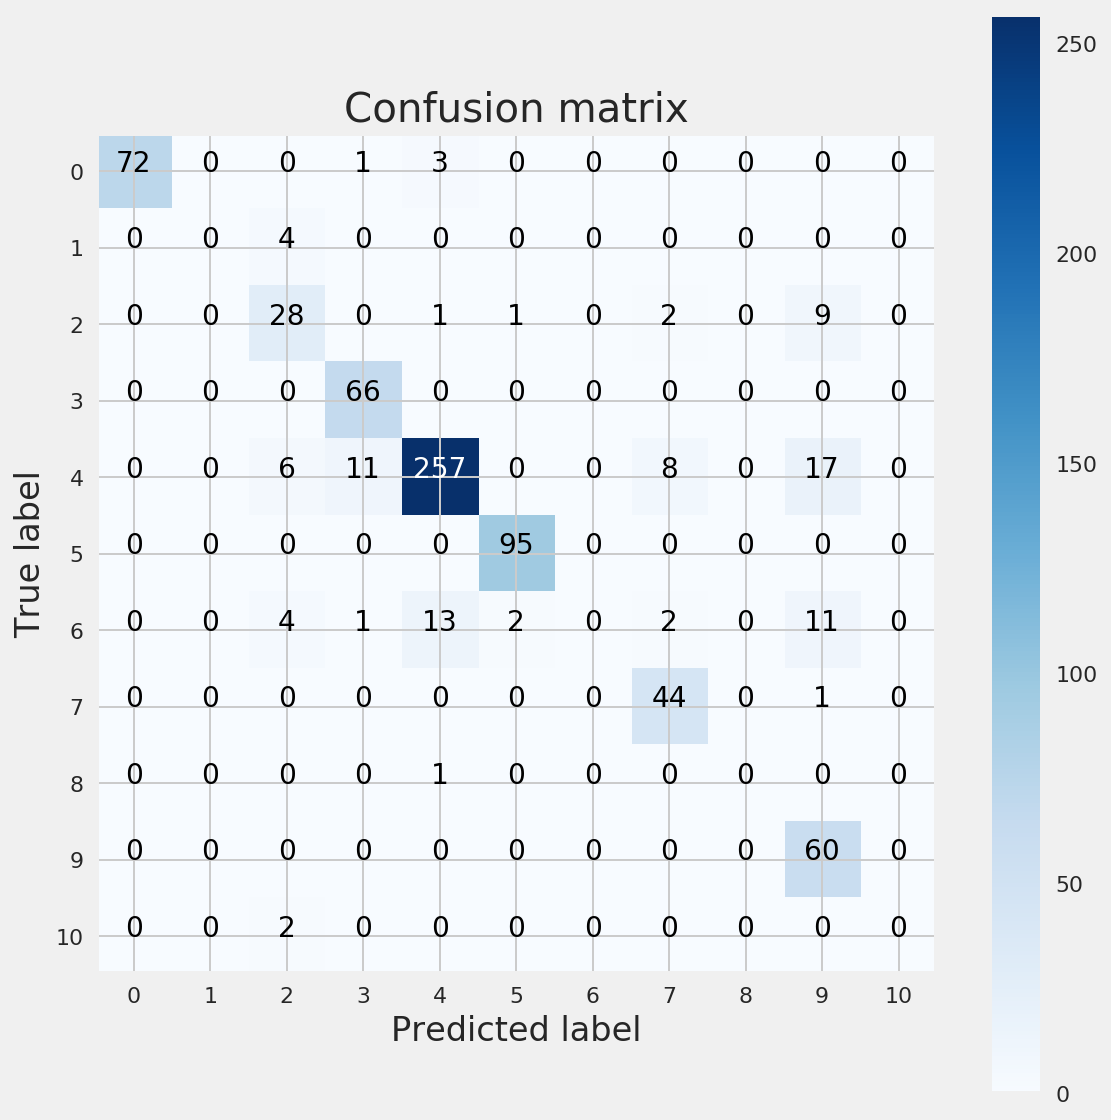

In [338]:
class_names = [i for i in range(11)]
cnf_matrix = confusion_matrix(Y_test, svc.predictions) 
np.set_printoptions(precision=2)
plt.figure(figsize = (8,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False, title='Confusion matrix')

___
#### 5.1.2 Learning curve

A typical way to test the quality of a fit is to draw a learning curve. In particular, this type of curves allow to detect possible drawbacks in the model, linked for example to over- or under-fitting. This also shows to which extent the mode could benefit from a larger data sample. In order to draw this curve, I use the [scikit-learn documentation code again](http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr- self-examples-model-selection-pad-learning-curve-py)

#### 学習曲線
フィットの品質をテストする一般的な方法は、学習曲線を描くことです。特に、このタイプの曲線を使用すると、モデルの潜在的な欠点を検出することができます。これは、たとえばオーバーフィッティングまたはアンダーフィッティングにリンクしています。これは、より大きなデータサンプルからモードがどの程度利益を得ることができるかも示しています。この曲線を描くために、私は再びscikit-learnドキュメンテーションコードを使用します

In [339]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

from which I represent the leanring curve of the SVC classifier:

ここから、SVC分類器の学習曲線を表します

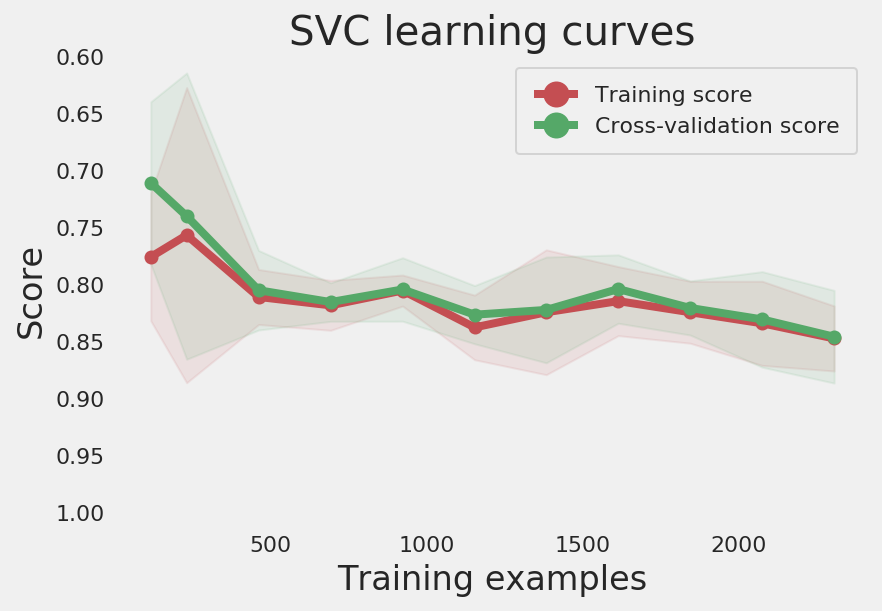

In [340]:
g = plot_learning_curve(svc.grid.best_estimator_,
                        "SVC learning curves", X_train, Y_train, ylim = [1.01, 0.6],
                        cv = 5,  train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                0.6, 0.7, 0.8, 0.9, 1])

On this curve, we can see that the train and cross-validation curves converge towards the same limit when the sample size increases. This is typical of modeling with low variance and proves that the model does not suffer from overfitting. Also, we can see that the accuracy of the training curve is correct which is synonymous of a low bias. Hence the model does not underfit the data.

この曲線では、サンプルサイズが大きくなると、トレインおよび交差検定曲線が同じ限界に向かって収束することがわかります。これは、分散が少ないモデリングの典型であり、モデルが過剰適合の影響を受けないことを証明しています。また、トレーニングカーブの精度が正しいことがわかります。これは、低バイアスの同義語です。そのため、モデルはデータにunderfitしません。

https://docs.aws.amazon.com/ja_jp/machine-learning/latest/dg/model-fit-underfitting-vs-overfitting.html
```
トレーニングデータでのモデルのパフォーマンスが悪いときは、モデルがトレーニングデータにアンダーフィットしています。これは、モデルが入力例 (X と呼ばれることが多い) とターゲット値 (Y と呼ばれることが多い) の関係をキャプチャできないことが原因です。トレーニングデータでのモデルのパフォーマンスがよくても、評価データでのパフォーマンスはよくないことが観察される場合、モデルがトレーニングデータにオーバーフィットしています。これは、モデルが見たデータを記憶していて、見ていない例に対して一般化できないことが原因です。

トレーニングデータでのパフォーマンスが悪い原因は、モデルがターゲットを説明するには単純すぎる (入力機能が十分に説明されていない) ことである可能性があります。モデルの柔軟性を高めることで、パフォーマンスを改善できます。モデルの柔軟性を高めるには、次の操作を試してください。

新しいドメイン固有の機能および機能のデカルト製品を追加する、また、機能処理のタイプを変更する (n グラムサイズの増加など)

使用する正則化の量を減らす

モデルがトレーニングデータにオーバーフィットしている場合は、モデルの柔軟性を低下させる措置を取るのが適切です。モデルの柔軟性を低下させるには、次の操作を試してください。

機能の選択: 機能の組み合わせを少なくする、n グラムのサイズを小さくする、および、数値属性ビンの数を減らすことを検討します。

使用する正則化の量を増やす。
```


### ロジスティック回帰
ロジスティック回帰分類器を検討します。前と同様に、Class_Fitクラスのインスタンスを作成し、トレーニングデータでモデルを調整し、予測が実際の値とどのように比較されるかを確認します。
___
### 5.2 Logistic Regression

I now consider the logistic regression classifier. As before, I create an instance of the `Class_Fit` class, adjust the model on the training data and see how the predictions compare to the real values:

In [341]:
lr = Class_Fit(clf = linear_model.LogisticRegression)
lr.grid_search(parameters = [{'C':np.logspace(-2,2,20)}], Kfold = 5)
lr.grid_fit(X = X_train, Y = Y_train)
lr.grid_predict(X_test, Y_test)

Precision: 89.89 % 


Then, I plot the learning curve to have a feeling of the quality of the model:

次に、学習曲線をプロットして、モデルの質を感じます。

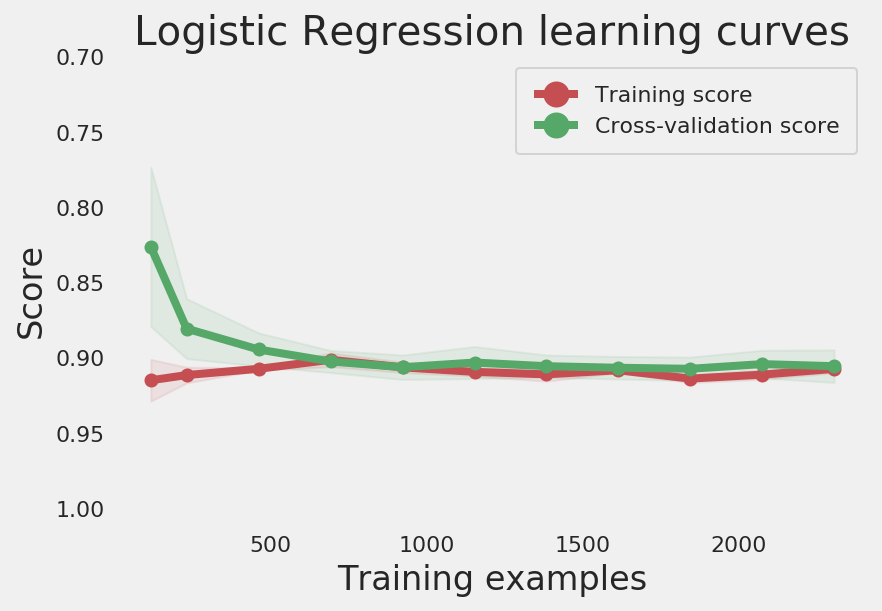

In [342]:
g = plot_learning_curve(lr.grid.best_estimator_, "Logistic Regression learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### 5.3 k-Nearest Neighbors

### k-最近傍法

In [343]:
knn = Class_Fit(clf = neighbors.KNeighborsClassifier)
knn.grid_search(parameters = [{'n_neighbors': np.arange(1,50,1)}], Kfold = 5)
knn.grid_fit(X = X_train, Y = Y_train)
knn.grid_predict(X_test, Y_test)

Precision: 79.22 % 


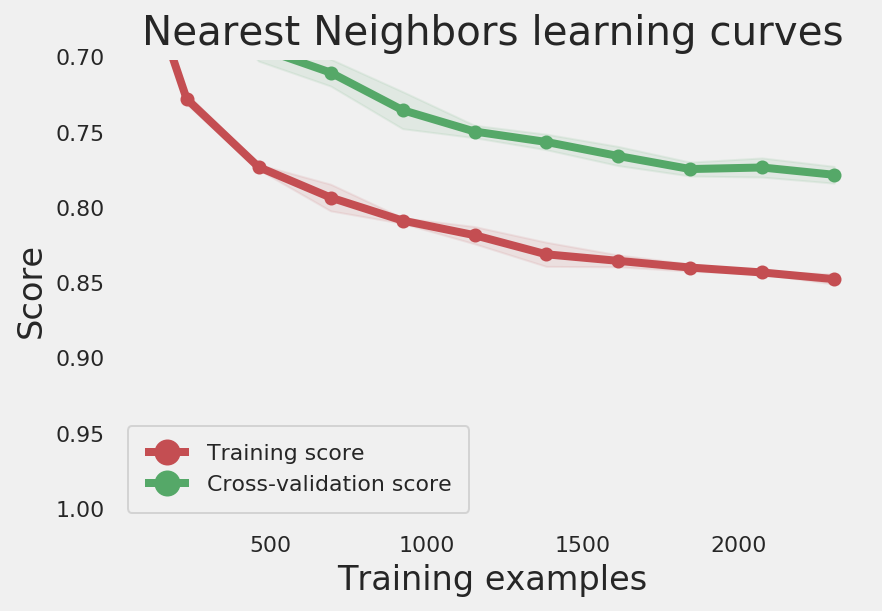

In [344]:
g = plot_learning_curve(knn.grid.best_estimator_, "Nearest Neighbors learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### 決定木

In [345]:
tr = Class_Fit(clf = tree.DecisionTreeClassifier)
tr.grid_search(parameters = [{'criterion' : ['entropy', 'gini'], 'max_features' :['sqrt', 'log2']}], Kfold = 5)
tr.grid_fit(X = X_train, Y = Y_train)
tr.grid_predict(X_test, Y_test)

Precision: 85.87 % 


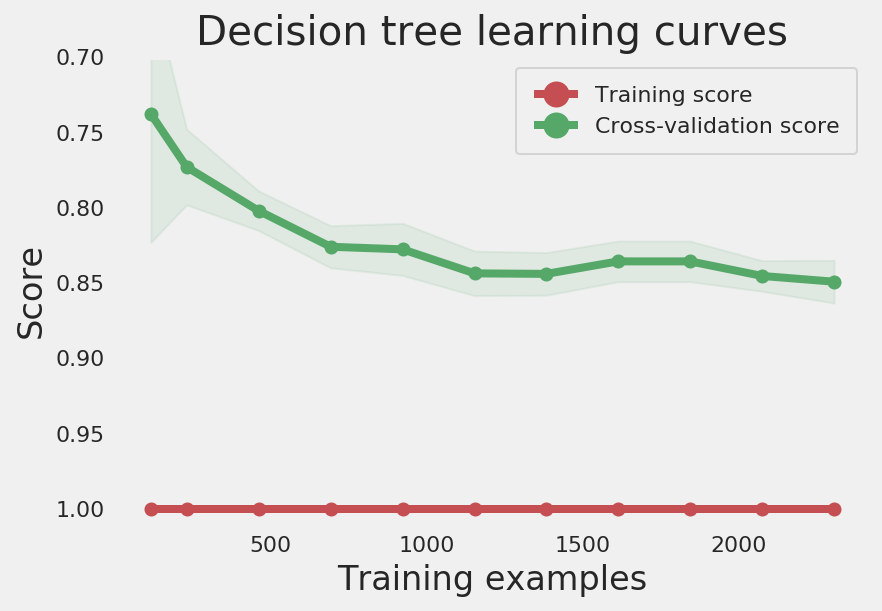

In [346]:
g = plot_learning_curve(tr.grid.best_estimator_, "Decision tree learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### ランダムフォレスト

In [347]:
rf = Class_Fit(clf = ensemble.RandomForestClassifier)
param_grid = {'criterion' : ['entropy', 'gini'], 'n_estimators' : [20, 40, 60, 80, 100],
               'max_features' :['sqrt', 'log2']}
rf.grid_search(parameters = param_grid, Kfold = 5)
rf.grid_fit(X = X_train, Y = Y_train)
rf.grid_predict(X_test, Y_test)

Precision: 90.72 % 


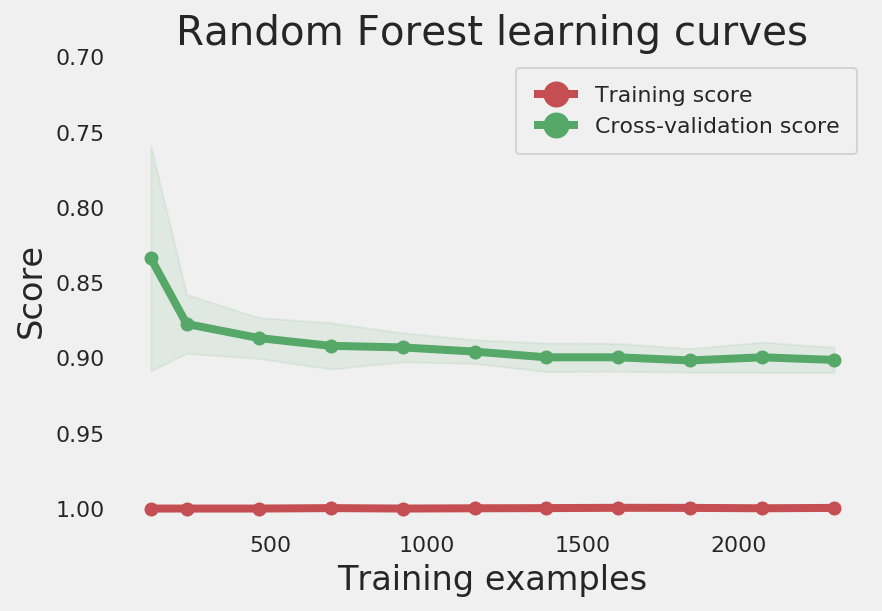

In [348]:
g = plot_learning_curve(rf.grid.best_estimator_, "Random Forest learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### AdaBoost
https://ja.wikipedia.org/wiki/AdaBoost
AdaBoostは前の分類機の間違いに応じて調整された次の分類機を作るという意味で適応的(Adaptive)である。AdaBoostはノイズの多いデータや異常値に影響を受ける。しかし、いくつかの場面では、多くの学習アルゴリズムより過剰適合の影響を受けにくい。

AdaBoost は、それぞれの標本に対し、弱い分類器（[weak classifier]）{\displaystyle t}tを、{\displaystyle t=1} t = 1から{\displaystyle t=T}t = Tまで順に適用し、それぞれの分類器が正解したか否かを判断する。間違って分類された標本に対応する重み{\displaystyle D_{t}}D_{t}は、より重くされる（あるいは、正しく分類された標本の場合は、重みを減らす）。これらの標本に対する重みから、次のtのループでは正しい分類器を早く探す事が出来る。

In [349]:
ada = Class_Fit(clf = AdaBoostClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
ada.grid_search(parameters = param_grid, Kfold = 5)
ada.grid_fit(X = X_train, Y = Y_train)
ada.grid_predict(X_test, Y_test)

Precision: 63.02 % 


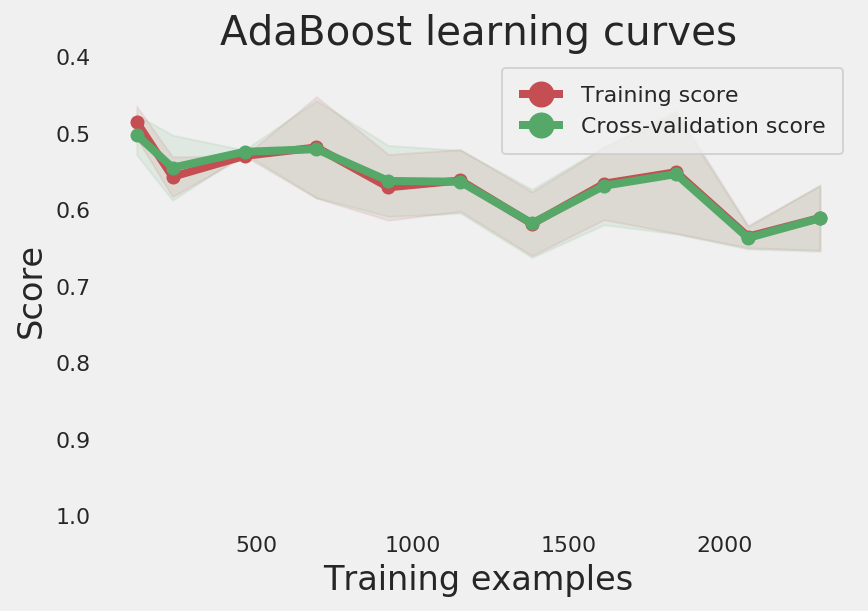

In [350]:
g = plot_learning_curve(ada.grid.best_estimator_, "AdaBoost learning curves", X_train, Y_train,
                        ylim = [1.01, 0.4], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### 5.7 Gradient Boosting Classifier　勾配ブースティング

https://qiita.com/woody_egg/items/232e982094cd3c80b3ee

1. モデルをデータにフィットさせる。

F1(x)=y
F1(x)=y
2.別のモデルを残差にフィットさせる。

h1(x)=y−F1(x)
h1(x)=y−F1(x)
3.新たなモデルを作る。

F2(x)=F1(x)+h1(x)
F2(x)=F1(x)+h1(x)
この考え方を一般化するのは難しくないでしょう。一つ前のモデルの残差を修正するような新しいモデルを足していけばいいだけですから。

F(x)=F1(x)⟼F2(x)=F1(x)+h1(x)…⟼FM(x)=FM−1(x)+hM−1(x)
F(x)=F1(x)⟼F2(x)=F1(x)+h1(x)…⟼FM(x)=FM−1(x)+hM−1(x)
(ここで、F1(x)F1(x)はyにフィットさせた最初のモデルとする)

この作業の最初にF1(x)F1(x)をフィットさせているので、各ステップでやるべきことはhhをフィットさせること、すなわちhm(x)=y−Fm(x)hm(x)=y−Fm(x)なるhmhmを見つけることです。
おや、ちょっと待ってください。ここでhmhmは単に「モデル」と言っているに過ぎず、木構造を持っていなければならないという制約はありません。これは勾配ブースティングのより一般的な概念であり、強みです。勾配ブースティングとは、あらゆる弱い学習機を繰り返し強化することができるという仕組みなのです。
ですので、理論的には、うまくプログラムが書かれていれば、勾配ブースティングモジュールにあなたの好きな弱い学習機クラスを「挿入」して使うことができます。実際には、hmhmはほぼ全て木の学習機なので、以下hmhmは今までの例と同じように回帰木と考えて差し支えありません。

In [351]:
gb = Class_Fit(clf = ensemble.GradientBoostingClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
gb.grid_search(parameters = param_grid, Kfold = 5)
gb.grid_fit(X = X_train, Y = Y_train)
gb.grid_predict(X_test, Y_test)

Precision: 90.72 % 


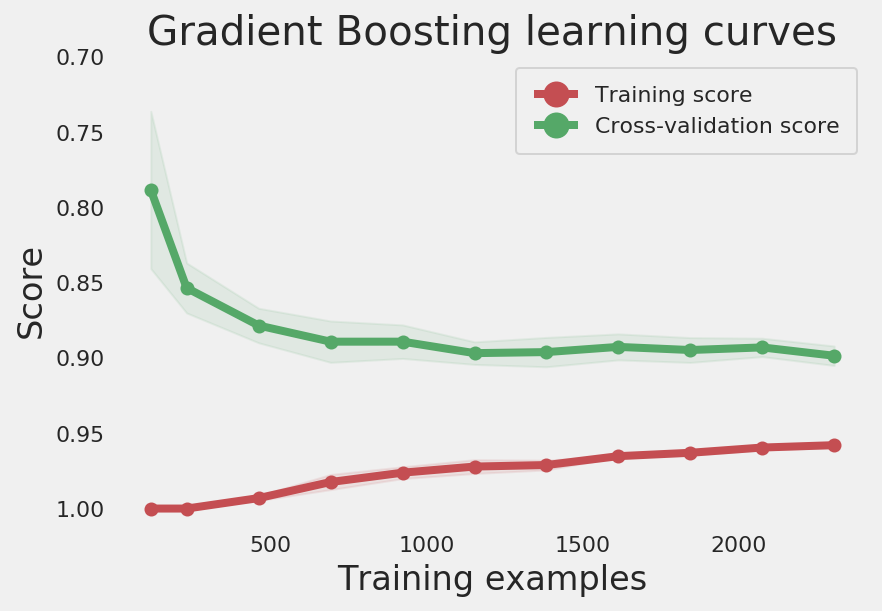

In [352]:
g = plot_learning_curve(gb.grid.best_estimator_, "Gradient Boosting learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

___
### VotingClassifier

Finally, the results of the different classifiers presented in the previous sections can be combined to improve the classification model. This can be achieved by selecting the customer category as the one indicated by the majority of classifiers. To do this, I use the `VotingClassifier` method of the `sklearn` package. As a first step, I adjust the parameters of the various classifiers using the *best* parameters previously found:

最後に、前のセクションで示したさまざまな分類器の結果を組み合わせて、分類モデルを改善できます。これは、大部分の分類子が示すものとして顧客カテゴリを選択することで実現できます。これを行うにVotingClassifierは、sklearnパッケージのメソッドを使用します。最初のステップとして、以前に見つけた最良のパラメーターを使用して、さまざまな分類器のパラメーターを調整します。
```
The idea behind the VotingClassifier is to combine conceptually different machine learning classifiers and use a majority vote or the average predicted probabilities (soft vote) to predict the class labels. Such a classifier can be useful for a set of equally well performing model in order to balance out their individual weaknesses.
（VotingClassifierの背景にある考え方は、コンセプトの異なる機械学習分類器を組み合わせ、
多数決や予測の平均(弱い投票)を使用し、クラスラベルを予測することです。
そのような分類器は個々の弱点を相殺するため、モデルの生成に有効である場合もあります。)
'1.11.5. Voting Classifier'. scikit-learn.org (参照 2019-2-6)
```

In [353]:
rf_best  = ensemble.RandomForestClassifier(**rf.grid.best_params_)
gb_best  = ensemble.GradientBoostingClassifier(**gb.grid.best_params_)
svc_best = svm.LinearSVC(**svc.grid.best_params_)
tr_best  = tree.DecisionTreeClassifier(**tr.grid.best_params_)
knn_best = neighbors.KNeighborsClassifier(**knn.grid.best_params_)
lr_best  = linear_model.LogisticRegression(**lr.grid.best_params_)

Then, I define a classifier that merges the results of the various classifiers:

次に、さまざまな分類子の結果をマージする分類子を定義します。

In [354]:
votingC = ensemble.VotingClassifier(estimators=[('rf', rf_best),('gb', gb_best),
                                                ('knn', knn_best)], voting='soft')    

そしてそれを訓練する：

In [355]:
votingC = votingC.fit(X_train, Y_train)

Finally, we can create a prediction for this model:

In [356]:
predictions = votingC.predict(X_test)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y_test, predictions)))

Precision: 91.69 % 


Note that when defining the `votingC` classifier, I only used a sub-sample of the whole set of classifiers defined above and only retained the *Random Forest*, the *k-Nearest Neighbors* and the *Gradient Boosting* classifiers. In practice, this choice has been done with respect to the performance of the classification carried out in the next section.

votingC分類子を定義するときは、上記で定義した分類子のセット全体のサブサンプルのみを使用し、Random Forest、k-Nearest Neighbors、およびGradient Boosting分類子のみを保持していることに注意してください。実際には、この選択は、次のセクションで実行される分類のパフォーマンスに関して行われています。
___
## 予測性能テスト

In the previous section, a few classifiers were trained in order to categorize customers. Until that point, the whole analysis was based on the data of the first 10 months. In this section, I test the model  the last two months of the dataset, that has been stored in the `set_test` dataframe:

前のセクションでは、顧客を分類するためにいくつかの分類器がトレーニングされました。その時点まで、分析全体は最初の10か月のデータに基づいていました。このセクションでは、データset_testフレームに保存されているデータセットの最後の2か月間でモデルをテストします。

In [357]:
basket_price = set_test.copy(deep = True)

In a first step, I regroup reformattes these data according to the same procedure as used on the training set. However, I am correcting the data to take into account the difference in time between the two datasets and weights the variables ** count ** and ** sum ** to obtain an equivalence with the training set:

最初のステップでは、トレーニングセットで使用したのと同じ手順に従ってこれらのデータを再フォーマットします。ただし、2つのデータセット間の時間差を考慮してデータを修正し、変数のカウントと合計に重みを付けて、トレーニングセットと同等になるようにします。

In [358]:
transactions_per_user=basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()

#_______________________
# Correcting time range
transactions_per_user['count'] = 5 * transactions_per_user['count']
transactions_per_user['sum']   = transactions_per_user['count'] * transactions_per_user['mean']

transactions_per_user.sort_values('CustomerID', ascending = True)[:5]

CustomerID  count      min      max     mean       sum    categ_0  \
0      12347     10   224.82  1294.32   759.57   7595.70  24.271627   
1      12349      5  1757.55  1757.55  1757.55   8787.75  10.713778   
2      12352      5   311.73   311.73   311.73   1558.65   7.217785   
3      12356      5    58.35    58.35    58.35    291.75   0.000000   
4      12357      5  6207.67  6207.67  6207.67  31038.35  28.350089   

      categ_1    categ_2    categ_3    categ_4  
0   17.732401  32.343299  20.017905   5.634767  
1   30.145373  12.245455  26.506216  20.389178  
2   32.335675   8.735123  34.420813  17.290604  
3  100.000000   0.000000   0.000000   0.000000  
4   13.300643  14.684737  18.475531  25.189000

Then, I convert the dataframe into a matrix and retain only variables that define the category to which consumers belong. At this level, I recall the method of normalization that had been used on the training set:

次に、データフレームをマトリックスに変換し、消費者が属するカテゴリを定義する変数のみを保持します。このレベルでは、トレーニングセットで使用されていた正規化の方法を思い出します。

In [359]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']
#_____________________________________________________________
matrix_test = transactions_per_user[list_cols].as_matrix()
scaled_test_matrix = scaler.transform(matrix_test)

Each line in this matrix contains a consumer's buying habits. At this stage, it is a question of using these habits in order to define the category to which the consumer belongs. These categories have been established in Section 4. ** At this stage, it is important to bear in mind that this step does not correspond to the classification stage itself**. Here, we prepare the test data by defining the category to which the customers belong. However, this definition uses data obtained over a period of 2 months (via the variables ** count **, ** min **, ** max ** and ** sum **). The classifier defined in Section 5 uses a more restricted set of variables that will be defined from the first purchase of a client.

Here it is a question of using the available data over a period of two months and using this data to define the category to which the customers belong. Then, the classifier can be tested by comparing its predictions with these categories. In order to define the category to which the clients belong, I recall the instance of the `kmeans` method used in section 4. The` predict` method of this instance calculates the distance of the consumers from the centroids of the 11 client classes and the smallest distance will define the belonging to the different categories:

このマトリックスの各行には、消費者の購買習慣が含まれています。この段階では、消費者が属するカテゴリを定義するためにこれらの習慣を使用することは問題です。これらのカテゴリはセクション4で設定されています。この段階では、このステップは分類段階自体に対応していないことに留意することが重要です。ここでは、顧客が属するカテゴリを定義して、テストデータを準備します。ただし、この定義では、2か月間（変数count、min、max、およびsumを介して）取得したデータを使用します。セクション5で定義された分類子は、クライアントの最初の購入から定義されるより制限された変数のセットを使用します。

ここでは、2か月間にわたって利用可能なデータを使用し、このデータを使用して顧客が属するカテゴリを定義するという問題があります。次に、予測をこれらのカテゴリと比較することにより、分類子をテストできます。クライアントが属するカテゴリを定義するためにkmeans、セクション4で使用したメソッドのインスタンスを思い出します。predictこのインスタンスのメソッドは、11のクライアントクラスの重心から消費者までの距離を計算し、最小距離はさまざまなカテゴリに属する​​：

In [360]:
Y = kmeans.predict(scaled_test_matrix)

Finally, in order to prepare the execution of the classifier, it is sufficient to select the variables on which it acts:

最後に、分類子の実行を準備するには、動作する変数を選択するだけで十分です。

In [361]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = transactions_per_user[columns]

It remains only to examine the predictions of the different classifiers that have been trained in section 5:

トレーニングされたさまざまな分類器の予測を調べる

In [362]:
classifiers = [(svc, 'Support Vector Machine'),
                (lr, 'Logostic Regression'),
                (knn, 'k-Nearest Neighbors'),
                (tr, 'Decision Tree'),
                (rf, 'Random Forest'),
                (gb, 'Gradient Boosting')]
#______________________________
for clf, label in classifiers:
    print(30*'_', '\n{}'.format(label))
    clf.grid_predict(X, Y)

______________________________ 
Support Vector Machine
Precision: 69.89 % 
______________________________ 
Logostic Regression
Precision: 75.07 % 
______________________________ 
k-Nearest Neighbors
Precision: 66.80 % 
______________________________ 
Decision Tree
Precision: 72.09 % 
______________________________ 
Random Forest
Precision: 74.72 % 
______________________________ 
Gradient Boosting
Precision: 75.15 % 


Finally, as anticipated in Section 5.8, it is possible to improve the quality of the classifier by combining their respective predictions. At this level, I chose to mix *Random Forest*, *Gradient Boosting* and *k-Nearest Neighbors* predictions because this leads to a slight improvement in predictions:

最後に、セクション5.8で予想されるように、それぞれの予測を組み合わせることにより、分類器の品質を向上させることができます。このレベルでは、ランダムフォレスト、勾配ブースティング、k-Nearest Neighborsの予測を組み合わせることを選択しました。これにより、予測がわずかに改善されるためです。

In [363]:
predictions = votingC.predict(X)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, predictions)))

Precision: 75.77 % 


___
## 7. Conclusion

The work described in this notebook is based on a database providing details on purchases made on an E-commerce platform over a period of one year. Each entry in the dataset describes the purchase of a product, by a particular customer and at a given date. In total, approximately $\sim$4000 clients appear in the database. Given the available information, I decided to develop a classifier that allows to anticipate the type of purchase that a customer will make, as well as the number of visits that he will make during a year, and this from its first visit to the E-commerce site.

The first stage of this work consisted in describing the different products sold by the site, which was the subject of a first classification. There, I grouped the different products into 5 main categories of goods. In a second step, I performed a classification of the customers by analyzing their consumption habits over a period of 10 months. I have classified clients into 11 major categories based on the type of products they usually buy, the number of visits they make and the amount they spent during the 10 months. Once these categories established, I finally trained several classifiers whose objective is to be able to classify consumers in one of these 11 categories and this from their first purchase. For this, the classifier is based on 5 variables which are:
- ** mean **: amount of the basket of the current purchase
- ** categ_N ** with $N \in [0: 4]$: percentage spent in product category with index $N$

Finally, the quality of the predictions of the different classifiers was tested over the last two months of the dataset. The data were then processed in two steps: first, all the data was considered (ober the 2 months) to define the category to which each client belongs, and then, the classifier predictions were compared with this category assignment. I then found that 75% of clients are awarded the right classes.
The performance of the classifier therefore seems correct given the potential shortcomings of the current model. In particular, a bias that has not been dealt with concerns the seasonality of purchases and the fact that purchasing habits will potentially depend on the time of year (for example, Christmas ). In practice, this seasonal effect may cause the categories defined over a 10-month period to be quite different from those extrapolated from the last two months. In order to correct such bias, it would be beneficial to have data that would cover a longer period of time.

## 結論
このノートブックに記載されている作業は、1年間のEコマースプラットフォームでの購入に関する詳細を提供するデータベースに基づいています。データセットの各エントリは、特定の顧客による特定の日付での製品の購入を表します。合計で、およそ 〜 4000クライアントがデータベースに表示されます。入手可能な情報を考慮して、顧客が行う購入のタイプと、1年間の訪問の数を予測できる分類器を開発することにしました。（これは最初のE-コマースサイトへの訪問から予測可能？？）。

この作業の最初の段階は、サイトで販売されているさまざまな製品を記述することであり、最初の分類の対象でした。そこで、さまざまな製品を5つの主要な商品カテゴリに分類しました。2番目のステップでは、10か月間の消費習慣を分析して、顧客の分類を行いました。私は、クライアントが通常購入する製品の種類、訪問数、10か月間に費やした金額に基づいて、クライアントを11の主要なカテゴリに分類しました。これらのカテゴリが確立したら、最終的にこれらの11のカテゴリのいずれかに消費者を分類できるようにすることを目的とした複数の分類子をトレーニングしました。このため、分類子は次の5つの変数に基づいています。

- mean：現在の購入のバスケットの量
- categ_Nと N∈ [ 0 ：4 ] ：インデックス付きの製品カテゴリで費やされた割合  N 

最後に、データセットの最後の2か月間で、さまざまな分類子の予測の質がテストされました。データは、2つのステップで処理されました。

最初に、すべてのデータ（2か月間）が考慮されて各クライアントが属するカテゴリが定義され、次に分類子予測がこのカテゴリ割り当てと比較されました。その後、75％のクライアントに適切なクラスが与えられていることがわかりました。

したがって、現在のモデルの潜在的な欠点を考慮すると、分類器のパフォーマンスは正しいように見えます。特に、対処されていないバイアスは、購入の季節性と、購入習慣が時期（たとえば、クリスマス）に依存する可能性があるという事実に関係しています。実際には、この季節的な影響により、10か月間に定義されたカテゴリは、過去2か月から推定されたカテゴリとはまったく異なる場合があります。そのようなバイアスを修正するためには、より長い期間をカバーするデータを持つことが有益です。